In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
from zipfile import ZipFile
from PIL import Image
import sys
import os
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

In [3]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        # transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(degrees=180),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=data_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics

In [5]:
class FeatureWeight(nn.Module):
    def __init__(self, in_depth, out_depth, **kwargs):
        super(FeatureWeight, self).__init__()

        self.fc1 = nn.Linear(in_depth, out_depth)
        self.bn1 = nn.BatchNorm1d(out_depth)
        self.bn_out = nn.BatchNorm2d(out_depth)

        self.conv2 = nn.Conv2d(out_depth, out_depth, kernel_size=(1,1), stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(out_depth)

    def forward(self, x1, x2):
        x1 = nn.AvgPool2d(kernel_size=(x1.size(-1), x1.size(-2)))(x1)
        x1 = nn.Flatten()(x1)
        x1 = self.fc1(x1)
        x1 = self.bn1(x1)
        x1 = nn.Sigmoid()(x1)

        x1 = x1.unsqueeze(-1).unsqueeze(-1)

        x2 = self.conv2(x2)
        x2 = self.bn2(x2)
        x2 = nn.ReLU()(x2)


        x_out = x1 * x2
        x_out = x_out + x2

        x_out = self.bn_out(x_out)

        return x_out


In [6]:
class SVUnit(nn.Module):
    def __init__(self, in_depth, out_depth, card=4, kernel_size=3, **kwargs):
        super(SVUnit, self).__init__()

        self.device = kwargs['device'] if 'device' in kwargs else 'cpu'

        self.pre_conv = nn.Sequential(nn.Conv2d(in_depth, out_depth, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(out_depth), nn.ReLU()).to(self.device)
        self.card = card
        self.paths = out_depth // self.card

        


        self.convs = []
        for i in range(self.paths):
            # self.convs.append(nn.Sequential(nn.Conv2d(out_depth, self.card, kernel_size=1, stride=1, padding=0),
            #                                 nn.BatchNorm2d(self.card), nn.ReLU(),
            #                                 nn.Conv2d(self.card, self.card, kernel_size=kernel_size, stride=1, padding=1),
            #                                 nn.BatchNorm2d(self.card), nn.ReLU(),
            #                                 nn.Conv2d(self.card, out_depth, kernel_size=1, stride=1, padding=0),
            #                                 nn.BatchNorm2d(out_depth), nn.ReLU()).to(self.device))

            self.convs.append(nn.Sequential(nn.Conv2d(out_depth, self.card, kernel_size=kernel_size, stride=1, padding=1),
                                            nn.BatchNorm2d(self.card), nn.ReLU(),
                                            nn.Conv2d(self.card, out_depth, kernel_size=kernel_size, stride=1, padding=1),
                                            nn.BatchNorm2d(out_depth), nn.ReLU()).to(self.device))

        self.bn_out = nn.BatchNorm2d(out_depth)
            
    def forward(self, x):
        x1 = self.pre_conv(x)

        x2 = self.convs[0](x1)

        for i in range(1, self.paths):
            x2 = x2 + self.convs[i](x1)

        x2 = x2 + x1

        x2 = self.bn_out(x2)

        return x2

In [6]:
class SVUnit(nn.Module):
    def __init__(self, in_depth, out_depth, card=4, kernel_size=3, **kwargs):
        super(SVUnit, self).__init__()

        self.device = kwargs['device'] if 'device' in kwargs else 'cpu'

        self.pre_conv = nn.Sequential(nn.Conv2d(in_depth, out_depth, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(out_depth), nn.ReLU()).to(self.device)
        self.card = card
        self.paths = out_depth // self.card

#         self.project_conv = nn.Sequential(nn.Conv2d(out_depth, out_depth, kernel_size=1, stride=1, padding=0),
#                                           nn.BatchNorm2d(out_depth), nn.ReLU()).to(self.device)


        self.convs = []
        for i in range(self.paths):
#             self.convs.append(nn.Sequential(nn.Conv2d(out_depth, self.card, kernel_size=1, stride=1, padding=0),
#                                             nn.BatchNorm2d(self.card), nn.ReLU(),
#                                             nn.Conv2d(self.card, self.card, kernel_size=kernel_size, stride=1, padding=1),
#                                             nn.BatchNorm2d(self.card), nn.ReLU(),
#                                             nn.Conv2d(self.card, out_depth, kernel_size=1, stride=1, padding=0),
#                                             nn.BatchNorm2d(out_depth), nn.ReLU()).to(self.device))

            self.convs.append(nn.Sequential(nn.Conv2d(out_depth, self.card, kernel_size=kernel_size, stride=1, padding=1),
                                            nn.BatchNorm2d(self.card), nn.ReLU()).to(self.device))

        self.bn_out = nn.BatchNorm2d(out_depth)
            
    def forward(self, x):
        x1 = self.pre_conv(x)
        
        x2 = torch.cat([layer(x1) for layer in self.convs], dim=1)
    
        x2 = x2 + x1

        x2 = self.bn_out(x2)

        return x2

In [7]:
class SVBlock(nn.Module):
    def __init__(self, in_depth, out_depth, kernel_size=3, **kwargs):
        super(SVBlock, self).__init__()

        self.device = kwargs['device'] if 'device' in kwargs else 'cpu'

        self.u1 = SVUnit(in_depth, out_depth, device=self.device)
        self.u2 = SVUnit(out_depth, out_depth, device=self.device)
        self.fw = FeatureWeight(out_depth, out_depth).to(self.device)
        self.bn_out = nn.BatchNorm2d(out_depth)

    def forward(self, x):
        x1 = self.u1(x)
        x2 = self.u2(x1)

        x_out = self.fw(x1, x2)
        x_out = x_out + x2
        x_out = self.bn_out(x_out)

        return x_out


In [8]:
class SVGG(nn.Module):
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = kwargs['device'] if 'device' in kwargs else torch.device('cpu')

        self.sv1 = SVBlock(1, 64, card=4, device=self.device)
        self.sv2 = SVBlock(64, 128, card=4, device=self.device)
        self.sv3 = SVBlock(128, 256, card=4, device=self.device)
        self.sv4 = SVBlock(256, 512, card=4, device=self.device)

        self.classifier = nn.Sequential(
            nn.AvgPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, 7),
            nn.BatchNorm1d(7)
        ).to(self.device)

    def forward(self, x):
        x = self.sv1(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = self.sv2(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = self.sv3(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = self.sv4(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        
        x = self.classifier(x)

        return x

In [9]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# model.train()

# model = model.to(device)

cuda


In [10]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_resnext.pt'
best_acc = 0.0
hist = []

for epoch in range(200):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc
        
#     scheduler.step()

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.258 acc: 0.117
	 - Step 2: loss: 1.968 acc: 0.180
	 - Step 3: loss: 2.044 acc: 0.125
	 - Step 4: loss: 2.066 acc: 0.211
	 - Step 5: loss: 1.986 acc: 0.227
	 - Step 6: loss: 1.931 acc: 0.227
	 - Step 7: loss: 1.997 acc: 0.273
	 - Step 8: loss: 2.051 acc: 0.258
	 - Step 9: loss: 1.945 acc: 0.211
	 - Step 10: loss: 1.976 acc: 0.188
	 - Step 11: loss: 2.092 acc: 0.250
	 - Step 12: loss: 2.034 acc: 0.219
	 - Step 13: loss: 2.066 acc: 0.195
	 - Step 14: loss: 2.028 acc: 0.273
	 - Step 15: loss: 1.983 acc: 0.211
	 - Step 16: loss: 1.846 acc: 0.273
	 - Step 17: loss: 2.061 acc: 0.219
	 - Step 18: loss: 2.035 acc: 0.195
	 - Step 19: loss: 2.152 acc: 0.180
	 - Step 20: loss: 1.865 acc: 0.219
	 - Step 21: loss: 2.026 acc: 0.234
	 - Step 22: loss: 1.889 acc: 0.188
	 - Step 23: loss: 2.042 acc: 0.289
	 - Step 24: loss: 1.837 acc: 0.305
	 - Step 25: loss: 2.013 acc: 0.211
	 - Step 26: loss: 1.900 acc: 0.234
	 - Step 27: loss: 1.865 acc: 0.297
	 - Step 28: loss: 2.077 ac

- Avg. val_loss: 1.579  | Avg. val_acc: 0.368
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVUnit. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FeatureWeight. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.588 acc: 0.398
	 - Step 2: loss: 1.543 acc: 0.414
	 - Step 3: loss: 1.386 acc: 0.508
	 - Step 4: loss: 1.515 acc: 0.414
	 - Step 5: loss: 1.516 acc: 0.414
	 - Step 6: loss: 1.617 acc: 0.328
	 - Step 7: loss: 1.576 acc: 0.406
	 - Step 8: loss: 1.609 acc: 0.375
	 - Step 9: loss: 1.525 acc: 0.375
	 - Step 10: loss: 1.542 acc: 0.352
	 - Step 11: loss: 1.600 acc: 0.398
	 - Step 12: loss: 1.553 acc: 0.430
	 - Step 13: loss: 1.548 acc: 0.344
	 - Step 14: loss: 1.455 acc: 0.445
	 - Step 15: loss: 1.511 acc: 0.406
	 - Step 16: loss: 1.531 acc: 0.398
	 - Step 17: loss: 1.454 acc: 0.414
	 - Step 18: loss: 1.543 acc: 0.422
	 - Step 19: loss: 1.375 acc: 0.484
	 - Step 20: loss: 1.460 acc: 0.477
	 - Step 21: loss: 1.546 acc: 0.344
	 - Step 22: loss: 1.452 acc: 0.422
	 - Step 23: loss: 1.557 acc: 0.406
	 - Step 24: loss: 1.380 acc: 0.469
	 - Step 25: loss: 1.618 acc: 0.359
	 - Step 26: loss: 1.364 acc: 0.484
	 - Step 27: loss: 1.434 acc: 0.516
	 - Step 28: loss: 1.480 acc: 0.414
	

- Avg. val_loss: 1.414  | Avg. val_acc: 0.471
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.317 acc: 0.461
	 - Step 2: loss: 1.330 acc: 0.445
	 - Step 3: loss: 1.347 acc: 0.484
	 - Step 4: loss: 1.255 acc: 0.547
	 - Step 5: loss: 1.323 acc: 0.461
	 - Step 6: loss: 1.236 acc: 0.539
	 - Step 7: loss: 1.327 acc: 0.492
	 - Step 8: loss: 1.254 acc: 0.531
	 - Step 9: loss: 1.430 acc: 0.383
	 - Step 10: loss: 1.342 acc: 0.461
	 - Step 11: loss: 1.422 acc: 0.391
	 - Step 12: loss: 1.285 acc: 0.469
	 - Step 13: loss: 1.300 acc: 0.461
	 - Step 14: loss: 1.359 acc: 0.477
	 - Step 15: loss: 1.238 acc: 0.523
	 - Step 16: loss: 1.362 acc: 0.430
	 - Step 17: loss: 1.258 acc: 0.516
	 - Step 18: loss: 1.380 acc: 0.477
	 - Step 19: loss: 1.391 acc: 0.438
	 - Step 20: loss: 1.275 acc: 0.508
	 - Step 21: loss: 1.221 acc: 0.531
	 - Step 22: loss: 1.290 acc: 0.547
	 - Step 23: loss: 1.260 acc: 0.508
	 - Step 24: loss: 1.417 acc: 0.484
	 - Step 25: loss: 1.270 acc: 0.469
	 - Step 26: loss: 1.250 acc: 

	 - Step 224: loss: 1.307 acc: 0.492
	 - Step 225: loss: 1.484 acc: 0.595
- Avg.loss: 1.274  | Avg.acc: 0.511
- Avg. val_loss: 1.294  | Avg. val_acc: 0.500
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.260 acc: 0.547
	 - Step 2: loss: 1.308 acc: 0.469
	 - Step 3: loss: 1.050 acc: 0.625
	 - Step 4: loss: 1.253 acc: 0.547
	 - Step 5: loss: 1.186 acc: 0.508
	 - Step 6: loss: 1.220 acc: 0.539
	 - Step 7: loss: 1.204 acc: 0.555
	 - Step 8: loss: 1.242 acc: 0.531
	 - Step 9: loss: 1.258 acc: 0.578
	 - Step 10: loss: 1.261 acc: 0.516
	 - Step 11: loss: 1.229 acc: 0.516
	 - Step 12: loss: 1.267 acc: 0.523
	 - Step 13: loss: 1.246 acc: 0.477
	 - Step 14: loss: 1.167 acc: 0.578
	 - Step 15: loss: 1.155 acc: 0.547
	 - Step 16: loss: 1.261 acc: 0.523
	 - Step 17: loss: 1.307 acc: 0.492
	 - Step 18: loss: 1.261 acc: 0.531
	 - Step 19: loss: 1.147 acc: 0.555
	 - Step 20: loss: 1.247 acc: 0.531
	 - Step 21: loss: 1.313 acc: 0.461
	 - Step 22: loss: 1.174 acc: 0.594
	 - Step 23: loss: 1.299 acc

	 - Step 221: loss: 1.372 acc: 0.523
	 - Step 222: loss: 1.219 acc: 0.570
	 - Step 223: loss: 1.397 acc: 0.453
	 - Step 224: loss: 1.193 acc: 0.555
	 - Step 225: loss: 1.185 acc: 0.541
- Avg.loss: 1.213  | Avg.acc: 0.535
- Avg. val_loss: 1.304  | Avg. val_acc: 0.511
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.090 acc: 0.570
	 - Step 2: loss: 1.188 acc: 0.555
	 - Step 3: loss: 1.281 acc: 0.547
	 - Step 4: loss: 1.218 acc: 0.578
	 - Step 5: loss: 1.241 acc: 0.500
	 - Step 6: loss: 1.303 acc: 0.469
	 - Step 7: loss: 1.417 acc: 0.445
	 - Step 8: loss: 1.263 acc: 0.516
	 - Step 9: loss: 1.229 acc: 0.531
	 - Step 10: loss: 1.143 acc: 0.531
	 - Step 11: loss: 1.060 acc: 0.609
	 - Step 12: loss: 1.248 acc: 0.547
	 - Step 13: loss: 1.256 acc: 0.570
	 - Step 14: loss: 1.204 acc: 0.531
	 - Step 15: loss: 1.158 acc: 0.531
	 - Step 16: loss: 1.101 acc: 0.555
	 - Step 17: loss: 1.286 acc: 0.484
	 - Step 18: loss: 1.133 acc: 0.523
	 - Step 19: loss: 1.120 acc: 0.570
	 - Step 20: loss: 1.271 

	 - Step 218: loss: 1.135 acc: 0.539
	 - Step 219: loss: 1.096 acc: 0.570
	 - Step 220: loss: 1.100 acc: 0.539
	 - Step 221: loss: 1.104 acc: 0.625
	 - Step 222: loss: 1.307 acc: 0.492
	 - Step 223: loss: 1.258 acc: 0.547
	 - Step 224: loss: 1.235 acc: 0.516
	 - Step 225: loss: 0.987 acc: 0.730
- Avg.loss: 1.191  | Avg.acc: 0.545
- Avg. val_loss: 1.284  | Avg. val_acc: 0.508
Epoch:  6
	 - Step 1: loss: 1.139 acc: 0.508
	 - Step 2: loss: 1.058 acc: 0.617
	 - Step 3: loss: 1.253 acc: 0.508
	 - Step 4: loss: 1.121 acc: 0.586
	 - Step 5: loss: 1.224 acc: 0.555
	 - Step 6: loss: 1.218 acc: 0.562
	 - Step 7: loss: 1.233 acc: 0.492
	 - Step 8: loss: 1.191 acc: 0.562
	 - Step 9: loss: 1.178 acc: 0.570
	 - Step 10: loss: 1.288 acc: 0.477
	 - Step 11: loss: 1.155 acc: 0.578
	 - Step 12: loss: 1.115 acc: 0.602
	 - Step 13: loss: 1.327 acc: 0.445
	 - Step 14: loss: 1.248 acc: 0.531
	 - Step 15: loss: 1.063 acc: 0.609
	 - Step 16: loss: 1.188 acc: 0.555
	 - Step 17: loss: 1.143 acc: 0.641
	 - Step 

	 - Step 215: loss: 1.090 acc: 0.648
	 - Step 216: loss: 1.041 acc: 0.625
	 - Step 217: loss: 1.214 acc: 0.578
	 - Step 218: loss: 1.220 acc: 0.547
	 - Step 219: loss: 1.309 acc: 0.484
	 - Step 220: loss: 1.158 acc: 0.570
	 - Step 221: loss: 1.213 acc: 0.547
	 - Step 222: loss: 1.190 acc: 0.578
	 - Step 223: loss: 1.064 acc: 0.586
	 - Step 224: loss: 1.072 acc: 0.531
	 - Step 225: loss: 1.515 acc: 0.514
- Avg.loss: 1.179  | Avg.acc: 0.554
- Avg. val_loss: 1.229  | Avg. val_acc: 0.539
* Update optimal model
Epoch:  7
	 - Step 1: loss: 1.054 acc: 0.648
	 - Step 2: loss: 1.149 acc: 0.594
	 - Step 3: loss: 1.056 acc: 0.656
	 - Step 4: loss: 1.238 acc: 0.523
	 - Step 5: loss: 1.174 acc: 0.570
	 - Step 6: loss: 1.192 acc: 0.570
	 - Step 7: loss: 1.542 acc: 0.453
	 - Step 8: loss: 1.055 acc: 0.602
	 - Step 9: loss: 1.132 acc: 0.547
	 - Step 10: loss: 1.063 acc: 0.648
	 - Step 11: loss: 1.264 acc: 0.492
	 - Step 12: loss: 1.256 acc: 0.500
	 - Step 13: loss: 1.366 acc: 0.453
	 - Step 14: loss: 

	 - Step 212: loss: 1.010 acc: 0.609
	 - Step 213: loss: 1.114 acc: 0.594
	 - Step 214: loss: 1.180 acc: 0.547
	 - Step 215: loss: 1.210 acc: 0.492
	 - Step 216: loss: 1.279 acc: 0.461
	 - Step 217: loss: 1.194 acc: 0.539
	 - Step 218: loss: 1.095 acc: 0.570
	 - Step 219: loss: 1.124 acc: 0.547
	 - Step 220: loss: 0.975 acc: 0.680
	 - Step 221: loss: 1.176 acc: 0.586
	 - Step 222: loss: 1.215 acc: 0.500
	 - Step 223: loss: 1.065 acc: 0.648
	 - Step 224: loss: 1.144 acc: 0.539
	 - Step 225: loss: 0.961 acc: 0.622
- Avg.loss: 1.163  | Avg.acc: 0.559
- Avg. val_loss: 1.220  | Avg. val_acc: 0.545
* Update optimal model
Epoch:  8
	 - Step 1: loss: 1.272 acc: 0.469
	 - Step 2: loss: 1.010 acc: 0.648
	 - Step 3: loss: 1.157 acc: 0.539
	 - Step 4: loss: 1.275 acc: 0.492
	 - Step 5: loss: 1.035 acc: 0.633
	 - Step 6: loss: 1.239 acc: 0.539
	 - Step 7: loss: 1.141 acc: 0.586
	 - Step 8: loss: 1.249 acc: 0.531
	 - Step 9: loss: 1.399 acc: 0.508
	 - Step 10: loss: 1.079 acc: 0.625
	 - Step 11: los

	 - Step 209: loss: 1.095 acc: 0.562
	 - Step 210: loss: 1.028 acc: 0.641
	 - Step 211: loss: 1.173 acc: 0.523
	 - Step 212: loss: 1.223 acc: 0.516
	 - Step 213: loss: 1.066 acc: 0.586
	 - Step 214: loss: 1.151 acc: 0.625
	 - Step 215: loss: 0.961 acc: 0.680
	 - Step 216: loss: 1.197 acc: 0.531
	 - Step 217: loss: 1.103 acc: 0.539
	 - Step 218: loss: 1.313 acc: 0.547
	 - Step 219: loss: 1.048 acc: 0.555
	 - Step 220: loss: 1.135 acc: 0.516
	 - Step 221: loss: 1.214 acc: 0.594
	 - Step 222: loss: 1.078 acc: 0.602
	 - Step 223: loss: 1.062 acc: 0.617
	 - Step 224: loss: 1.096 acc: 0.555
	 - Step 225: loss: 1.387 acc: 0.432
- Avg.loss: 1.150  | Avg.acc: 0.564
- Avg. val_loss: 1.202  | Avg. val_acc: 0.535
Epoch:  9
	 - Step 1: loss: 1.098 acc: 0.625
	 - Step 2: loss: 1.011 acc: 0.602
	 - Step 3: loss: 1.102 acc: 0.602
	 - Step 4: loss: 1.175 acc: 0.523
	 - Step 5: loss: 1.263 acc: 0.508
	 - Step 6: loss: 1.090 acc: 0.594
	 - Step 7: loss: 1.149 acc: 0.586
	 - Step 8: loss: 1.132 acc: 0.562

	 - Step 206: loss: 1.188 acc: 0.547
	 - Step 207: loss: 1.123 acc: 0.523
	 - Step 208: loss: 1.252 acc: 0.508
	 - Step 209: loss: 1.060 acc: 0.633
	 - Step 210: loss: 1.053 acc: 0.648
	 - Step 211: loss: 1.177 acc: 0.578
	 - Step 212: loss: 0.950 acc: 0.648
	 - Step 213: loss: 1.170 acc: 0.539
	 - Step 214: loss: 1.143 acc: 0.578
	 - Step 215: loss: 1.185 acc: 0.555
	 - Step 216: loss: 1.107 acc: 0.617
	 - Step 217: loss: 1.222 acc: 0.500
	 - Step 218: loss: 1.054 acc: 0.602
	 - Step 219: loss: 1.093 acc: 0.570
	 - Step 220: loss: 1.046 acc: 0.656
	 - Step 221: loss: 1.064 acc: 0.602
	 - Step 222: loss: 1.164 acc: 0.562
	 - Step 223: loss: 1.370 acc: 0.547
	 - Step 224: loss: 1.238 acc: 0.562
	 - Step 225: loss: 1.463 acc: 0.432
- Avg.loss: 1.148  | Avg.acc: 0.565
- Avg. val_loss: 1.240  | Avg. val_acc: 0.514
Epoch:  10
	 - Step 1: loss: 0.960 acc: 0.664
	 - Step 2: loss: 1.078 acc: 0.578
	 - Step 3: loss: 1.103 acc: 0.648
	 - Step 4: loss: 1.194 acc: 0.555
	 - Step 5: loss: 1.152 acc

	 - Step 203: loss: 1.012 acc: 0.617
	 - Step 204: loss: 1.167 acc: 0.562
	 - Step 205: loss: 1.183 acc: 0.539
	 - Step 206: loss: 1.176 acc: 0.602
	 - Step 207: loss: 1.410 acc: 0.484
	 - Step 208: loss: 1.179 acc: 0.523
	 - Step 209: loss: 1.140 acc: 0.617
	 - Step 210: loss: 1.328 acc: 0.422
	 - Step 211: loss: 0.963 acc: 0.656
	 - Step 212: loss: 1.037 acc: 0.648
	 - Step 213: loss: 1.052 acc: 0.602
	 - Step 214: loss: 1.196 acc: 0.523
	 - Step 215: loss: 1.250 acc: 0.531
	 - Step 216: loss: 1.081 acc: 0.594
	 - Step 217: loss: 1.064 acc: 0.562
	 - Step 218: loss: 1.116 acc: 0.602
	 - Step 219: loss: 1.338 acc: 0.438
	 - Step 220: loss: 1.113 acc: 0.594
	 - Step 221: loss: 1.185 acc: 0.516
	 - Step 222: loss: 1.082 acc: 0.516
	 - Step 223: loss: 1.193 acc: 0.547
	 - Step 224: loss: 1.047 acc: 0.633
	 - Step 225: loss: 1.109 acc: 0.622
- Avg.loss: 1.134  | Avg.acc: 0.567
- Avg. val_loss: 1.239  | Avg. val_acc: 0.526
Epoch:  11
	 - Step 1: loss: 1.097 acc: 0.609
	 - Step 2: loss: 1.2

	 - Step 200: loss: 1.342 acc: 0.516
	 - Step 201: loss: 1.098 acc: 0.547
	 - Step 202: loss: 1.117 acc: 0.633
	 - Step 203: loss: 1.108 acc: 0.578
	 - Step 204: loss: 1.183 acc: 0.555
	 - Step 205: loss: 1.091 acc: 0.562
	 - Step 206: loss: 1.088 acc: 0.602
	 - Step 207: loss: 1.114 acc: 0.578
	 - Step 208: loss: 1.026 acc: 0.617
	 - Step 209: loss: 1.164 acc: 0.609
	 - Step 210: loss: 1.220 acc: 0.586
	 - Step 211: loss: 1.325 acc: 0.508
	 - Step 212: loss: 0.994 acc: 0.656
	 - Step 213: loss: 1.255 acc: 0.523
	 - Step 214: loss: 1.174 acc: 0.547
	 - Step 215: loss: 1.178 acc: 0.484
	 - Step 216: loss: 1.202 acc: 0.531
	 - Step 217: loss: 1.116 acc: 0.586
	 - Step 218: loss: 1.114 acc: 0.555
	 - Step 219: loss: 1.085 acc: 0.609
	 - Step 220: loss: 1.110 acc: 0.484
	 - Step 221: loss: 1.138 acc: 0.578
	 - Step 222: loss: 0.937 acc: 0.703
	 - Step 223: loss: 1.117 acc: 0.586
	 - Step 224: loss: 1.159 acc: 0.555
	 - Step 225: loss: 1.241 acc: 0.514
- Avg.loss: 1.128  | Avg.acc: 0.569
- 

	 - Step 197: loss: 1.061 acc: 0.539
	 - Step 198: loss: 1.235 acc: 0.523
	 - Step 199: loss: 1.018 acc: 0.625
	 - Step 200: loss: 0.991 acc: 0.641
	 - Step 201: loss: 1.152 acc: 0.508
	 - Step 202: loss: 1.185 acc: 0.508
	 - Step 203: loss: 1.157 acc: 0.523
	 - Step 204: loss: 1.181 acc: 0.578
	 - Step 205: loss: 1.043 acc: 0.633
	 - Step 206: loss: 1.139 acc: 0.555
	 - Step 207: loss: 1.179 acc: 0.586
	 - Step 208: loss: 1.051 acc: 0.609
	 - Step 209: loss: 1.110 acc: 0.609
	 - Step 210: loss: 1.116 acc: 0.570
	 - Step 211: loss: 1.181 acc: 0.516
	 - Step 212: loss: 1.229 acc: 0.555
	 - Step 213: loss: 1.297 acc: 0.531
	 - Step 214: loss: 1.175 acc: 0.508
	 - Step 215: loss: 1.177 acc: 0.578
	 - Step 216: loss: 1.098 acc: 0.609
	 - Step 217: loss: 1.074 acc: 0.609
	 - Step 218: loss: 1.229 acc: 0.562
	 - Step 219: loss: 1.127 acc: 0.570
	 - Step 220: loss: 1.079 acc: 0.578
	 - Step 221: loss: 1.151 acc: 0.570
	 - Step 222: loss: 1.111 acc: 0.609
	 - Step 223: loss: 1.292 acc: 0.516
	

	 - Step 194: loss: 1.068 acc: 0.594
	 - Step 195: loss: 1.143 acc: 0.594
	 - Step 196: loss: 1.150 acc: 0.562
	 - Step 197: loss: 0.985 acc: 0.633
	 - Step 198: loss: 1.237 acc: 0.516
	 - Step 199: loss: 1.054 acc: 0.633
	 - Step 200: loss: 1.191 acc: 0.484
	 - Step 201: loss: 1.060 acc: 0.609
	 - Step 202: loss: 1.031 acc: 0.617
	 - Step 203: loss: 1.072 acc: 0.602
	 - Step 204: loss: 1.210 acc: 0.508
	 - Step 205: loss: 1.037 acc: 0.609
	 - Step 206: loss: 1.131 acc: 0.570
	 - Step 207: loss: 1.001 acc: 0.602
	 - Step 208: loss: 0.928 acc: 0.641
	 - Step 209: loss: 1.101 acc: 0.578
	 - Step 210: loss: 1.154 acc: 0.562
	 - Step 211: loss: 1.089 acc: 0.594
	 - Step 212: loss: 1.234 acc: 0.562
	 - Step 213: loss: 1.274 acc: 0.508
	 - Step 214: loss: 1.060 acc: 0.633
	 - Step 215: loss: 1.036 acc: 0.648
	 - Step 216: loss: 0.997 acc: 0.578
	 - Step 217: loss: 1.058 acc: 0.562
	 - Step 218: loss: 1.037 acc: 0.586
	 - Step 219: loss: 1.164 acc: 0.578
	 - Step 220: loss: 1.085 acc: 0.539
	

	 - Step 191: loss: 1.115 acc: 0.547
	 - Step 192: loss: 1.049 acc: 0.578
	 - Step 193: loss: 0.985 acc: 0.641
	 - Step 194: loss: 1.188 acc: 0.531
	 - Step 195: loss: 1.015 acc: 0.617
	 - Step 196: loss: 1.067 acc: 0.602
	 - Step 197: loss: 1.106 acc: 0.586
	 - Step 198: loss: 1.023 acc: 0.625
	 - Step 199: loss: 1.104 acc: 0.555
	 - Step 200: loss: 1.058 acc: 0.602
	 - Step 201: loss: 1.283 acc: 0.516
	 - Step 202: loss: 1.123 acc: 0.555
	 - Step 203: loss: 1.220 acc: 0.531
	 - Step 204: loss: 1.301 acc: 0.477
	 - Step 205: loss: 1.089 acc: 0.594
	 - Step 206: loss: 1.216 acc: 0.508
	 - Step 207: loss: 1.047 acc: 0.602
	 - Step 208: loss: 1.125 acc: 0.539
	 - Step 209: loss: 1.247 acc: 0.516
	 - Step 210: loss: 1.131 acc: 0.531
	 - Step 211: loss: 1.104 acc: 0.492
	 - Step 212: loss: 1.094 acc: 0.531
	 - Step 213: loss: 1.142 acc: 0.586
	 - Step 214: loss: 0.979 acc: 0.586
	 - Step 215: loss: 1.045 acc: 0.609
	 - Step 216: loss: 1.136 acc: 0.570
	 - Step 217: loss: 1.118 acc: 0.578
	

	 - Step 188: loss: 1.169 acc: 0.555
	 - Step 189: loss: 1.138 acc: 0.555
	 - Step 190: loss: 1.040 acc: 0.625
	 - Step 191: loss: 1.108 acc: 0.547
	 - Step 192: loss: 1.050 acc: 0.578
	 - Step 193: loss: 1.122 acc: 0.578
	 - Step 194: loss: 1.167 acc: 0.523
	 - Step 195: loss: 1.237 acc: 0.594
	 - Step 196: loss: 1.217 acc: 0.516
	 - Step 197: loss: 1.101 acc: 0.539
	 - Step 198: loss: 1.170 acc: 0.523
	 - Step 199: loss: 1.237 acc: 0.562
	 - Step 200: loss: 1.035 acc: 0.586
	 - Step 201: loss: 0.942 acc: 0.617
	 - Step 202: loss: 0.956 acc: 0.648
	 - Step 203: loss: 1.226 acc: 0.523
	 - Step 204: loss: 1.205 acc: 0.539
	 - Step 205: loss: 1.152 acc: 0.594
	 - Step 206: loss: 1.180 acc: 0.500
	 - Step 207: loss: 1.055 acc: 0.578
	 - Step 208: loss: 0.918 acc: 0.664
	 - Step 209: loss: 1.113 acc: 0.555
	 - Step 210: loss: 1.058 acc: 0.531
	 - Step 211: loss: 1.210 acc: 0.531
	 - Step 212: loss: 1.127 acc: 0.539
	 - Step 213: loss: 1.169 acc: 0.578
	 - Step 214: loss: 1.137 acc: 0.539
	

	 - Step 185: loss: 1.059 acc: 0.570
	 - Step 186: loss: 1.158 acc: 0.586
	 - Step 187: loss: 1.186 acc: 0.539
	 - Step 188: loss: 1.185 acc: 0.578
	 - Step 189: loss: 1.201 acc: 0.555
	 - Step 190: loss: 1.139 acc: 0.594
	 - Step 191: loss: 1.117 acc: 0.570
	 - Step 192: loss: 1.170 acc: 0.555
	 - Step 193: loss: 0.987 acc: 0.664
	 - Step 194: loss: 1.131 acc: 0.531
	 - Step 195: loss: 1.128 acc: 0.500
	 - Step 196: loss: 1.235 acc: 0.516
	 - Step 197: loss: 1.179 acc: 0.539
	 - Step 198: loss: 0.959 acc: 0.656
	 - Step 199: loss: 1.117 acc: 0.578
	 - Step 200: loss: 1.008 acc: 0.641
	 - Step 201: loss: 1.157 acc: 0.570
	 - Step 202: loss: 1.181 acc: 0.555
	 - Step 203: loss: 1.054 acc: 0.648
	 - Step 204: loss: 1.045 acc: 0.633
	 - Step 205: loss: 1.261 acc: 0.555
	 - Step 206: loss: 1.012 acc: 0.625
	 - Step 207: loss: 1.189 acc: 0.578
	 - Step 208: loss: 1.024 acc: 0.617
	 - Step 209: loss: 1.085 acc: 0.602
	 - Step 210: loss: 1.106 acc: 0.578
	 - Step 211: loss: 1.185 acc: 0.516
	

	 - Step 182: loss: 1.058 acc: 0.578
	 - Step 183: loss: 1.249 acc: 0.500
	 - Step 184: loss: 1.039 acc: 0.570
	 - Step 185: loss: 1.130 acc: 0.570
	 - Step 186: loss: 1.198 acc: 0.477
	 - Step 187: loss: 1.018 acc: 0.641
	 - Step 188: loss: 1.241 acc: 0.570
	 - Step 189: loss: 1.127 acc: 0.609
	 - Step 190: loss: 0.975 acc: 0.656
	 - Step 191: loss: 1.223 acc: 0.547
	 - Step 192: loss: 1.021 acc: 0.633
	 - Step 193: loss: 1.152 acc: 0.594
	 - Step 194: loss: 1.319 acc: 0.500
	 - Step 195: loss: 1.121 acc: 0.586
	 - Step 196: loss: 1.137 acc: 0.555
	 - Step 197: loss: 1.080 acc: 0.570
	 - Step 198: loss: 1.058 acc: 0.625
	 - Step 199: loss: 1.088 acc: 0.633
	 - Step 200: loss: 1.150 acc: 0.586
	 - Step 201: loss: 1.189 acc: 0.539
	 - Step 202: loss: 1.153 acc: 0.578
	 - Step 203: loss: 1.056 acc: 0.586
	 - Step 204: loss: 1.082 acc: 0.555
	 - Step 205: loss: 0.958 acc: 0.633
	 - Step 206: loss: 1.027 acc: 0.633
	 - Step 207: loss: 1.199 acc: 0.547
	 - Step 208: loss: 1.037 acc: 0.602
	

	 - Step 179: loss: 1.012 acc: 0.633
	 - Step 180: loss: 0.957 acc: 0.625
	 - Step 181: loss: 0.946 acc: 0.578
	 - Step 182: loss: 1.069 acc: 0.586
	 - Step 183: loss: 1.085 acc: 0.570
	 - Step 184: loss: 1.090 acc: 0.586
	 - Step 185: loss: 1.246 acc: 0.523
	 - Step 186: loss: 0.993 acc: 0.641
	 - Step 187: loss: 1.059 acc: 0.586
	 - Step 188: loss: 1.197 acc: 0.531
	 - Step 189: loss: 1.049 acc: 0.625
	 - Step 190: loss: 0.969 acc: 0.641
	 - Step 191: loss: 1.166 acc: 0.531
	 - Step 192: loss: 1.131 acc: 0.555
	 - Step 193: loss: 1.203 acc: 0.531
	 - Step 194: loss: 1.194 acc: 0.547
	 - Step 195: loss: 1.070 acc: 0.578
	 - Step 196: loss: 1.057 acc: 0.641
	 - Step 197: loss: 1.139 acc: 0.562
	 - Step 198: loss: 1.107 acc: 0.625
	 - Step 199: loss: 1.146 acc: 0.539
	 - Step 200: loss: 1.096 acc: 0.594
	 - Step 201: loss: 1.074 acc: 0.602
	 - Step 202: loss: 1.187 acc: 0.562
	 - Step 203: loss: 1.182 acc: 0.578
	 - Step 204: loss: 1.119 acc: 0.555
	 - Step 205: loss: 1.069 acc: 0.609
	

	 - Step 176: loss: 1.096 acc: 0.562
	 - Step 177: loss: 1.122 acc: 0.531
	 - Step 178: loss: 1.041 acc: 0.562
	 - Step 179: loss: 1.057 acc: 0.617
	 - Step 180: loss: 1.113 acc: 0.484
	 - Step 181: loss: 1.061 acc: 0.586
	 - Step 182: loss: 1.211 acc: 0.523
	 - Step 183: loss: 1.020 acc: 0.602
	 - Step 184: loss: 1.136 acc: 0.547
	 - Step 185: loss: 1.209 acc: 0.539
	 - Step 186: loss: 1.045 acc: 0.609
	 - Step 187: loss: 1.105 acc: 0.570
	 - Step 188: loss: 1.196 acc: 0.555
	 - Step 189: loss: 1.182 acc: 0.547
	 - Step 190: loss: 1.060 acc: 0.609
	 - Step 191: loss: 1.174 acc: 0.531
	 - Step 192: loss: 0.953 acc: 0.664
	 - Step 193: loss: 1.112 acc: 0.555
	 - Step 194: loss: 1.222 acc: 0.547
	 - Step 195: loss: 1.139 acc: 0.570
	 - Step 196: loss: 1.080 acc: 0.609
	 - Step 197: loss: 1.067 acc: 0.594
	 - Step 198: loss: 1.030 acc: 0.625
	 - Step 199: loss: 1.130 acc: 0.578
	 - Step 200: loss: 1.011 acc: 0.648
	 - Step 201: loss: 1.099 acc: 0.539
	 - Step 202: loss: 1.180 acc: 0.562
	

	 - Step 173: loss: 1.091 acc: 0.617
	 - Step 174: loss: 1.075 acc: 0.586
	 - Step 175: loss: 1.203 acc: 0.570
	 - Step 176: loss: 1.008 acc: 0.602
	 - Step 177: loss: 1.054 acc: 0.578
	 - Step 178: loss: 1.096 acc: 0.531
	 - Step 179: loss: 1.151 acc: 0.562
	 - Step 180: loss: 1.307 acc: 0.492
	 - Step 181: loss: 1.130 acc: 0.578
	 - Step 182: loss: 1.003 acc: 0.609
	 - Step 183: loss: 1.208 acc: 0.547
	 - Step 184: loss: 1.051 acc: 0.609
	 - Step 185: loss: 1.129 acc: 0.555
	 - Step 186: loss: 1.170 acc: 0.523
	 - Step 187: loss: 1.006 acc: 0.648
	 - Step 188: loss: 1.186 acc: 0.562
	 - Step 189: loss: 1.075 acc: 0.594
	 - Step 190: loss: 0.955 acc: 0.688
	 - Step 191: loss: 1.199 acc: 0.547
	 - Step 192: loss: 1.106 acc: 0.586
	 - Step 193: loss: 1.042 acc: 0.602
	 - Step 194: loss: 1.173 acc: 0.500
	 - Step 195: loss: 1.054 acc: 0.578
	 - Step 196: loss: 1.133 acc: 0.586
	 - Step 197: loss: 1.091 acc: 0.602
	 - Step 198: loss: 1.111 acc: 0.578
	 - Step 199: loss: 1.048 acc: 0.531
	

	 - Step 170: loss: 1.044 acc: 0.594
	 - Step 171: loss: 1.228 acc: 0.516
	 - Step 172: loss: 1.124 acc: 0.578
	 - Step 173: loss: 0.951 acc: 0.586
	 - Step 174: loss: 1.066 acc: 0.578
	 - Step 175: loss: 1.039 acc: 0.555
	 - Step 176: loss: 1.094 acc: 0.625
	 - Step 177: loss: 1.111 acc: 0.602
	 - Step 178: loss: 0.991 acc: 0.625
	 - Step 179: loss: 1.165 acc: 0.531
	 - Step 180: loss: 1.058 acc: 0.617
	 - Step 181: loss: 1.191 acc: 0.578
	 - Step 182: loss: 1.312 acc: 0.500
	 - Step 183: loss: 1.116 acc: 0.578
	 - Step 184: loss: 1.030 acc: 0.609
	 - Step 185: loss: 1.031 acc: 0.602
	 - Step 186: loss: 1.110 acc: 0.625
	 - Step 187: loss: 1.042 acc: 0.609
	 - Step 188: loss: 1.145 acc: 0.578
	 - Step 189: loss: 1.119 acc: 0.625
	 - Step 190: loss: 1.014 acc: 0.586
	 - Step 191: loss: 1.039 acc: 0.570
	 - Step 192: loss: 1.046 acc: 0.633
	 - Step 193: loss: 1.121 acc: 0.562
	 - Step 194: loss: 1.048 acc: 0.594
	 - Step 195: loss: 1.033 acc: 0.602
	 - Step 196: loss: 1.066 acc: 0.609
	

	 - Step 167: loss: 1.029 acc: 0.594
	 - Step 168: loss: 1.066 acc: 0.562
	 - Step 169: loss: 1.094 acc: 0.555
	 - Step 170: loss: 1.094 acc: 0.570
	 - Step 171: loss: 1.034 acc: 0.609
	 - Step 172: loss: 0.987 acc: 0.609
	 - Step 173: loss: 1.086 acc: 0.547
	 - Step 174: loss: 1.205 acc: 0.523
	 - Step 175: loss: 1.004 acc: 0.609
	 - Step 176: loss: 1.299 acc: 0.508
	 - Step 177: loss: 1.111 acc: 0.570
	 - Step 178: loss: 1.151 acc: 0.648
	 - Step 179: loss: 1.120 acc: 0.570
	 - Step 180: loss: 1.034 acc: 0.602
	 - Step 181: loss: 1.102 acc: 0.625
	 - Step 182: loss: 1.161 acc: 0.609
	 - Step 183: loss: 1.019 acc: 0.672
	 - Step 184: loss: 1.033 acc: 0.617
	 - Step 185: loss: 1.001 acc: 0.594
	 - Step 186: loss: 1.035 acc: 0.633
	 - Step 187: loss: 1.094 acc: 0.617
	 - Step 188: loss: 1.140 acc: 0.578
	 - Step 189: loss: 1.001 acc: 0.633
	 - Step 190: loss: 0.958 acc: 0.664
	 - Step 191: loss: 1.163 acc: 0.555
	 - Step 192: loss: 1.095 acc: 0.555
	 - Step 193: loss: 0.974 acc: 0.617
	

	 - Step 164: loss: 1.054 acc: 0.617
	 - Step 165: loss: 1.019 acc: 0.648
	 - Step 166: loss: 1.060 acc: 0.617
	 - Step 167: loss: 1.071 acc: 0.617
	 - Step 168: loss: 1.148 acc: 0.539
	 - Step 169: loss: 0.922 acc: 0.680
	 - Step 170: loss: 1.047 acc: 0.625
	 - Step 171: loss: 0.972 acc: 0.656
	 - Step 172: loss: 1.138 acc: 0.523
	 - Step 173: loss: 1.091 acc: 0.617
	 - Step 174: loss: 1.114 acc: 0.578
	 - Step 175: loss: 1.149 acc: 0.570
	 - Step 176: loss: 1.251 acc: 0.523
	 - Step 177: loss: 1.155 acc: 0.586
	 - Step 178: loss: 1.224 acc: 0.516
	 - Step 179: loss: 1.276 acc: 0.484
	 - Step 180: loss: 1.049 acc: 0.602
	 - Step 181: loss: 0.956 acc: 0.609
	 - Step 182: loss: 1.134 acc: 0.570
	 - Step 183: loss: 1.118 acc: 0.578
	 - Step 184: loss: 1.111 acc: 0.602
	 - Step 185: loss: 1.222 acc: 0.539
	 - Step 186: loss: 1.103 acc: 0.570
	 - Step 187: loss: 1.161 acc: 0.508
	 - Step 188: loss: 1.039 acc: 0.602
	 - Step 189: loss: 1.077 acc: 0.594
	 - Step 190: loss: 1.215 acc: 0.523
	

	 - Step 161: loss: 1.127 acc: 0.578
	 - Step 162: loss: 1.195 acc: 0.562
	 - Step 163: loss: 1.236 acc: 0.516
	 - Step 164: loss: 1.122 acc: 0.602
	 - Step 165: loss: 1.080 acc: 0.578
	 - Step 166: loss: 1.164 acc: 0.523
	 - Step 167: loss: 1.191 acc: 0.516
	 - Step 168: loss: 1.195 acc: 0.555
	 - Step 169: loss: 1.149 acc: 0.508
	 - Step 170: loss: 1.054 acc: 0.578
	 - Step 171: loss: 0.958 acc: 0.633
	 - Step 172: loss: 1.045 acc: 0.602


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	 - Step 205: loss: 1.010 acc: 0.594
	 - Step 206: loss: 1.046 acc: 0.656
	 - Step 207: loss: 1.057 acc: 0.594
	 - Step 208: loss: 0.990 acc: 0.609
	 - Step 209: loss: 1.090 acc: 0.602
	 - Step 210: loss: 1.139 acc: 0.586
	 - Step 211: loss: 1.000 acc: 0.633
	 - Step 212: loss: 1.103 acc: 0.500
	 - Step 213: loss: 0.968 acc: 0.594
	 - Step 214: loss: 1.131 acc: 0.562
	 - Step 215: loss: 1.039 acc: 0.570
	 - Step 216: loss: 1.119 acc: 0.523
	 - Step 217: loss: 1.138 acc: 0.531
	 - Step 218: loss: 1.077 acc: 0.602
	 - Step 219: loss: 0.902 acc: 0.641
	 - Step 220: loss: 1.119 acc: 0.586
	 - Step 221: loss: 1.138 acc: 0.547
	 - Step 222: loss: 1.150 acc: 0.586
	 - Step 223: loss: 0.944 acc: 0.656
	 - Step 224: loss: 1.147 acc: 0.586
	 - Step 225: loss: 1.135 acc: 0.541
- Avg.loss: 1.048  | Avg.acc: 0.604
- Avg. val_loss: 1.124  | Avg. val_acc: 0.576
Epoch:  58
	 - Step 1: loss: 0.997 acc: 0.617
	 - Step 2: loss: 0.953 acc: 0.617
	 - Step 3: loss: 1.101 acc: 0.594
	 - Step 4: loss: 1.011 a

	 - Step 202: loss: 1.087 acc: 0.570
	 - Step 203: loss: 0.956 acc: 0.641
	 - Step 204: loss: 1.026 acc: 0.609
	 - Step 205: loss: 1.150 acc: 0.562
	 - Step 206: loss: 0.846 acc: 0.711
	 - Step 207: loss: 1.120 acc: 0.594
	 - Step 208: loss: 1.032 acc: 0.617
	 - Step 209: loss: 1.024 acc: 0.633
	 - Step 210: loss: 1.049 acc: 0.602
	 - Step 211: loss: 1.122 acc: 0.578
	 - Step 212: loss: 1.006 acc: 0.633
	 - Step 213: loss: 1.074 acc: 0.562
	 - Step 214: loss: 1.020 acc: 0.594
	 - Step 215: loss: 1.286 acc: 0.508
	 - Step 216: loss: 1.145 acc: 0.562
	 - Step 217: loss: 1.009 acc: 0.602
	 - Step 218: loss: 1.043 acc: 0.641
	 - Step 219: loss: 1.163 acc: 0.539
	 - Step 220: loss: 1.115 acc: 0.602
	 - Step 221: loss: 1.019 acc: 0.609
	 - Step 222: loss: 1.289 acc: 0.445
	 - Step 223: loss: 1.311 acc: 0.484
	 - Step 224: loss: 0.970 acc: 0.688
	 - Step 225: loss: 1.007 acc: 0.649
- Avg.loss: 1.048  | Avg.acc: 0.605
- Avg. val_loss: 1.149  | Avg. val_acc: 0.571
Epoch:  59
	 - Step 1: loss: 1

	 - Step 199: loss: 1.084 acc: 0.586
	 - Step 200: loss: 1.023 acc: 0.617
	 - Step 201: loss: 1.046 acc: 0.625
	 - Step 202: loss: 1.042 acc: 0.617
	 - Step 203: loss: 1.019 acc: 0.625
	 - Step 204: loss: 1.060 acc: 0.625
	 - Step 205: loss: 1.061 acc: 0.570
	 - Step 206: loss: 0.916 acc: 0.625
	 - Step 207: loss: 1.096 acc: 0.594
	 - Step 208: loss: 1.027 acc: 0.617
	 - Step 209: loss: 1.068 acc: 0.594
	 - Step 210: loss: 1.174 acc: 0.516
	 - Step 211: loss: 1.029 acc: 0.617
	 - Step 212: loss: 1.002 acc: 0.602
	 - Step 213: loss: 0.948 acc: 0.680
	 - Step 214: loss: 1.042 acc: 0.609
	 - Step 215: loss: 1.050 acc: 0.703
	 - Step 216: loss: 1.173 acc: 0.578
	 - Step 217: loss: 1.134 acc: 0.523
	 - Step 218: loss: 1.025 acc: 0.664
	 - Step 219: loss: 1.248 acc: 0.555
	 - Step 220: loss: 0.889 acc: 0.656
	 - Step 221: loss: 0.909 acc: 0.688
	 - Step 222: loss: 1.000 acc: 0.648
	 - Step 223: loss: 1.105 acc: 0.578
	 - Step 224: loss: 1.007 acc: 0.602
	 - Step 225: loss: 1.333 acc: 0.486
-

	 - Step 196: loss: 1.220 acc: 0.531
	 - Step 197: loss: 1.111 acc: 0.570
	 - Step 198: loss: 1.043 acc: 0.609
	 - Step 199: loss: 1.108 acc: 0.578
	 - Step 200: loss: 1.062 acc: 0.586
	 - Step 201: loss: 1.074 acc: 0.625
	 - Step 202: loss: 1.012 acc: 0.609
	 - Step 203: loss: 1.088 acc: 0.578
	 - Step 204: loss: 1.183 acc: 0.539
	 - Step 205: loss: 1.175 acc: 0.523
	 - Step 206: loss: 1.056 acc: 0.609
	 - Step 207: loss: 1.145 acc: 0.547
	 - Step 208: loss: 0.991 acc: 0.641
	 - Step 209: loss: 1.189 acc: 0.500
	 - Step 210: loss: 1.164 acc: 0.570
	 - Step 211: loss: 1.052 acc: 0.602
	 - Step 212: loss: 1.025 acc: 0.633
	 - Step 213: loss: 1.031 acc: 0.570
	 - Step 214: loss: 1.159 acc: 0.562
	 - Step 215: loss: 1.019 acc: 0.609
	 - Step 216: loss: 1.136 acc: 0.578
	 - Step 217: loss: 1.242 acc: 0.570
	 - Step 218: loss: 1.002 acc: 0.625
	 - Step 219: loss: 1.044 acc: 0.641
	 - Step 220: loss: 1.047 acc: 0.625
	 - Step 221: loss: 1.007 acc: 0.656
	 - Step 222: loss: 0.941 acc: 0.641
	

	 - Step 193: loss: 1.038 acc: 0.625
	 - Step 194: loss: 0.965 acc: 0.633
	 - Step 195: loss: 1.094 acc: 0.586
	 - Step 196: loss: 1.072 acc: 0.609
	 - Step 197: loss: 1.133 acc: 0.539
	 - Step 198: loss: 1.115 acc: 0.586
	 - Step 199: loss: 1.117 acc: 0.578
	 - Step 200: loss: 1.057 acc: 0.547
	 - Step 201: loss: 1.063 acc: 0.602
	 - Step 202: loss: 1.216 acc: 0.539
	 - Step 203: loss: 1.134 acc: 0.570
	 - Step 204: loss: 1.143 acc: 0.508
	 - Step 205: loss: 1.065 acc: 0.594
	 - Step 206: loss: 1.058 acc: 0.562
	 - Step 207: loss: 0.894 acc: 0.648
	 - Step 208: loss: 1.087 acc: 0.562
	 - Step 209: loss: 0.995 acc: 0.664
	 - Step 210: loss: 0.939 acc: 0.617
	 - Step 211: loss: 1.061 acc: 0.641
	 - Step 212: loss: 0.951 acc: 0.664
	 - Step 213: loss: 0.918 acc: 0.688
	 - Step 214: loss: 1.123 acc: 0.539
	 - Step 215: loss: 1.070 acc: 0.609
	 - Step 216: loss: 1.073 acc: 0.602
	 - Step 217: loss: 1.043 acc: 0.609
	 - Step 218: loss: 1.160 acc: 0.562
	 - Step 219: loss: 0.978 acc: 0.625
	

	 - Step 190: loss: 1.137 acc: 0.570
	 - Step 191: loss: 1.108 acc: 0.555
	 - Step 192: loss: 1.050 acc: 0.609
	 - Step 193: loss: 0.835 acc: 0.688
	 - Step 194: loss: 0.993 acc: 0.617
	 - Step 195: loss: 0.952 acc: 0.617
	 - Step 196: loss: 1.000 acc: 0.617
	 - Step 197: loss: 1.133 acc: 0.586
	 - Step 198: loss: 1.047 acc: 0.633
	 - Step 199: loss: 1.010 acc: 0.625
	 - Step 200: loss: 1.124 acc: 0.570
	 - Step 201: loss: 1.103 acc: 0.617
	 - Step 202: loss: 1.190 acc: 0.516
	 - Step 203: loss: 0.934 acc: 0.711
	 - Step 204: loss: 0.992 acc: 0.633
	 - Step 205: loss: 0.890 acc: 0.680
	 - Step 206: loss: 0.905 acc: 0.711
	 - Step 207: loss: 0.970 acc: 0.648
	 - Step 208: loss: 1.217 acc: 0.531
	 - Step 209: loss: 0.928 acc: 0.656
	 - Step 210: loss: 1.035 acc: 0.641
	 - Step 211: loss: 1.058 acc: 0.602
	 - Step 212: loss: 1.074 acc: 0.602
	 - Step 213: loss: 1.083 acc: 0.641
	 - Step 214: loss: 1.145 acc: 0.633
	 - Step 215: loss: 1.009 acc: 0.578
	 - Step 216: loss: 0.941 acc: 0.617
	

	 - Step 187: loss: 1.150 acc: 0.531
	 - Step 188: loss: 1.104 acc: 0.625
	 - Step 189: loss: 0.919 acc: 0.672
	 - Step 190: loss: 1.087 acc: 0.555
	 - Step 191: loss: 1.083 acc: 0.562
	 - Step 192: loss: 1.072 acc: 0.633
	 - Step 193: loss: 0.922 acc: 0.641
	 - Step 194: loss: 1.057 acc: 0.555
	 - Step 195: loss: 1.251 acc: 0.461
	 - Step 196: loss: 1.075 acc: 0.586
	 - Step 197: loss: 1.045 acc: 0.625
	 - Step 198: loss: 1.181 acc: 0.586
	 - Step 199: loss: 1.050 acc: 0.617
	 - Step 200: loss: 1.013 acc: 0.633
	 - Step 201: loss: 1.116 acc: 0.602
	 - Step 202: loss: 1.092 acc: 0.578
	 - Step 203: loss: 0.938 acc: 0.633
	 - Step 204: loss: 0.881 acc: 0.664
	 - Step 205: loss: 1.145 acc: 0.555
	 - Step 206: loss: 1.130 acc: 0.508
	 - Step 207: loss: 1.028 acc: 0.648
	 - Step 208: loss: 1.015 acc: 0.617
	 - Step 209: loss: 1.067 acc: 0.609
	 - Step 210: loss: 1.036 acc: 0.633
	 - Step 211: loss: 1.031 acc: 0.641
	 - Step 212: loss: 0.862 acc: 0.672
	 - Step 213: loss: 1.052 acc: 0.609
	

	 - Step 184: loss: 1.020 acc: 0.617
	 - Step 185: loss: 1.096 acc: 0.625
	 - Step 186: loss: 0.921 acc: 0.641
	 - Step 187: loss: 1.057 acc: 0.586
	 - Step 188: loss: 1.258 acc: 0.531
	 - Step 189: loss: 1.177 acc: 0.586
	 - Step 190: loss: 1.059 acc: 0.570
	 - Step 191: loss: 1.035 acc: 0.633
	 - Step 192: loss: 1.038 acc: 0.641
	 - Step 193: loss: 1.148 acc: 0.562
	 - Step 194: loss: 1.029 acc: 0.609
	 - Step 195: loss: 0.975 acc: 0.656
	 - Step 196: loss: 1.061 acc: 0.586
	 - Step 197: loss: 1.073 acc: 0.570
	 - Step 198: loss: 0.995 acc: 0.625
	 - Step 199: loss: 1.144 acc: 0.578
	 - Step 200: loss: 1.054 acc: 0.586
	 - Step 201: loss: 1.098 acc: 0.547
	 - Step 202: loss: 0.957 acc: 0.609
	 - Step 203: loss: 1.210 acc: 0.539
	 - Step 204: loss: 1.287 acc: 0.547
	 - Step 205: loss: 1.121 acc: 0.578
	 - Step 206: loss: 1.169 acc: 0.523
	 - Step 207: loss: 1.089 acc: 0.562
	 - Step 208: loss: 1.196 acc: 0.594
	 - Step 209: loss: 0.876 acc: 0.672
	 - Step 210: loss: 0.996 acc: 0.656
	

	 - Step 181: loss: 1.019 acc: 0.609
	 - Step 182: loss: 0.943 acc: 0.680
	 - Step 183: loss: 1.050 acc: 0.562
	 - Step 184: loss: 0.985 acc: 0.625
	 - Step 185: loss: 1.041 acc: 0.625
	 - Step 186: loss: 0.901 acc: 0.711
	 - Step 187: loss: 1.023 acc: 0.648
	 - Step 188: loss: 1.105 acc: 0.617
	 - Step 189: loss: 1.103 acc: 0.625
	 - Step 190: loss: 1.189 acc: 0.594
	 - Step 191: loss: 0.855 acc: 0.680
	 - Step 192: loss: 1.050 acc: 0.609
	 - Step 193: loss: 1.020 acc: 0.578
	 - Step 194: loss: 0.959 acc: 0.648
	 - Step 195: loss: 1.103 acc: 0.547
	 - Step 196: loss: 0.999 acc: 0.617
	 - Step 197: loss: 1.020 acc: 0.672
	 - Step 198: loss: 1.009 acc: 0.594
	 - Step 199: loss: 1.059 acc: 0.586
	 - Step 200: loss: 0.967 acc: 0.641
	 - Step 201: loss: 1.311 acc: 0.539
	 - Step 202: loss: 0.964 acc: 0.609
	 - Step 203: loss: 1.310 acc: 0.500
	 - Step 204: loss: 1.006 acc: 0.617
	 - Step 205: loss: 0.971 acc: 0.617
	 - Step 206: loss: 0.995 acc: 0.641
	 - Step 207: loss: 1.128 acc: 0.516
	

	 - Step 178: loss: 1.033 acc: 0.602
	 - Step 179: loss: 1.112 acc: 0.625
	 - Step 180: loss: 1.022 acc: 0.586
	 - Step 181: loss: 1.126 acc: 0.586
	 - Step 182: loss: 0.955 acc: 0.648
	 - Step 183: loss: 1.085 acc: 0.578
	 - Step 184: loss: 1.048 acc: 0.609
	 - Step 185: loss: 1.166 acc: 0.578
	 - Step 186: loss: 1.112 acc: 0.578
	 - Step 187: loss: 1.176 acc: 0.562
	 - Step 188: loss: 1.099 acc: 0.578
	 - Step 189: loss: 1.010 acc: 0.625
	 - Step 190: loss: 1.104 acc: 0.562
	 - Step 191: loss: 1.013 acc: 0.625
	 - Step 192: loss: 1.145 acc: 0.609
	 - Step 193: loss: 1.033 acc: 0.617
	 - Step 194: loss: 1.138 acc: 0.609
	 - Step 195: loss: 1.085 acc: 0.570
	 - Step 196: loss: 0.942 acc: 0.656
	 - Step 197: loss: 0.932 acc: 0.625
	 - Step 198: loss: 1.118 acc: 0.570
	 - Step 199: loss: 0.974 acc: 0.641
	 - Step 200: loss: 1.104 acc: 0.570
	 - Step 201: loss: 1.008 acc: 0.602
	 - Step 202: loss: 1.115 acc: 0.594
	 - Step 203: loss: 1.067 acc: 0.594
	 - Step 204: loss: 1.012 acc: 0.633
	

	 - Step 175: loss: 0.933 acc: 0.680
	 - Step 176: loss: 1.059 acc: 0.586
	 - Step 177: loss: 1.003 acc: 0.578
	 - Step 178: loss: 0.958 acc: 0.602
	 - Step 179: loss: 1.107 acc: 0.578
	 - Step 180: loss: 1.059 acc: 0.633
	 - Step 181: loss: 1.103 acc: 0.602
	 - Step 182: loss: 1.130 acc: 0.594
	 - Step 183: loss: 1.159 acc: 0.570
	 - Step 184: loss: 0.989 acc: 0.594
	 - Step 185: loss: 1.083 acc: 0.539
	 - Step 186: loss: 0.966 acc: 0.656
	 - Step 187: loss: 1.041 acc: 0.625
	 - Step 188: loss: 1.028 acc: 0.641
	 - Step 189: loss: 1.011 acc: 0.648
	 - Step 190: loss: 1.095 acc: 0.633
	 - Step 191: loss: 1.068 acc: 0.562
	 - Step 192: loss: 1.035 acc: 0.594
	 - Step 193: loss: 0.943 acc: 0.617
	 - Step 194: loss: 0.927 acc: 0.688
	 - Step 195: loss: 0.907 acc: 0.703
	 - Step 196: loss: 1.194 acc: 0.508
	 - Step 197: loss: 1.132 acc: 0.586
	 - Step 198: loss: 1.026 acc: 0.609
	 - Step 199: loss: 0.952 acc: 0.656
	 - Step 200: loss: 1.019 acc: 0.586
	 - Step 201: loss: 0.946 acc: 0.656
	

	 - Step 172: loss: 0.938 acc: 0.688
	 - Step 173: loss: 0.908 acc: 0.672
	 - Step 174: loss: 1.010 acc: 0.625
	 - Step 175: loss: 1.144 acc: 0.500
	 - Step 176: loss: 1.066 acc: 0.633
	 - Step 177: loss: 0.999 acc: 0.602
	 - Step 178: loss: 1.154 acc: 0.570
	 - Step 179: loss: 0.957 acc: 0.648
	 - Step 180: loss: 1.069 acc: 0.578
	 - Step 181: loss: 1.061 acc: 0.594
	 - Step 182: loss: 1.213 acc: 0.578
	 - Step 183: loss: 1.113 acc: 0.617
	 - Step 184: loss: 1.221 acc: 0.570
	 - Step 185: loss: 1.088 acc: 0.625
	 - Step 186: loss: 1.027 acc: 0.602
	 - Step 187: loss: 0.901 acc: 0.664
	 - Step 188: loss: 1.086 acc: 0.641
	 - Step 189: loss: 0.989 acc: 0.617
	 - Step 190: loss: 1.073 acc: 0.594
	 - Step 191: loss: 1.131 acc: 0.562
	 - Step 192: loss: 0.889 acc: 0.656
	 - Step 193: loss: 1.041 acc: 0.641
	 - Step 194: loss: 1.060 acc: 0.609
	 - Step 195: loss: 0.937 acc: 0.656
	 - Step 196: loss: 1.162 acc: 0.562
	 - Step 197: loss: 1.062 acc: 0.641
	 - Step 198: loss: 1.084 acc: 0.570
	

	 - Step 169: loss: 0.914 acc: 0.695
	 - Step 170: loss: 1.035 acc: 0.617
	 - Step 171: loss: 1.044 acc: 0.617
	 - Step 172: loss: 1.137 acc: 0.562
	 - Step 173: loss: 1.047 acc: 0.625
	 - Step 174: loss: 1.058 acc: 0.617
	 - Step 175: loss: 1.030 acc: 0.594
	 - Step 176: loss: 1.115 acc: 0.562
	 - Step 177: loss: 0.961 acc: 0.617
	 - Step 178: loss: 0.997 acc: 0.664
	 - Step 179: loss: 1.015 acc: 0.648
	 - Step 180: loss: 0.982 acc: 0.664
	 - Step 181: loss: 1.180 acc: 0.531
	 - Step 182: loss: 0.974 acc: 0.633
	 - Step 183: loss: 0.991 acc: 0.625
	 - Step 184: loss: 1.121 acc: 0.594
	 - Step 185: loss: 0.987 acc: 0.664
	 - Step 186: loss: 1.129 acc: 0.547
	 - Step 187: loss: 1.043 acc: 0.656
	 - Step 188: loss: 0.985 acc: 0.648
	 - Step 189: loss: 1.265 acc: 0.531
	 - Step 190: loss: 1.053 acc: 0.617
	 - Step 191: loss: 1.115 acc: 0.617
	 - Step 192: loss: 1.028 acc: 0.625
	 - Step 193: loss: 1.086 acc: 0.586
	 - Step 194: loss: 1.158 acc: 0.523
	 - Step 195: loss: 0.940 acc: 0.656
	

	 - Step 166: loss: 1.049 acc: 0.633
	 - Step 167: loss: 1.147 acc: 0.609
	 - Step 168: loss: 1.179 acc: 0.586
	 - Step 169: loss: 0.931 acc: 0.680
	 - Step 170: loss: 1.014 acc: 0.625
	 - Step 171: loss: 1.101 acc: 0.555
	 - Step 172: loss: 1.023 acc: 0.578
	 - Step 173: loss: 1.158 acc: 0.570
	 - Step 174: loss: 0.977 acc: 0.633
	 - Step 175: loss: 1.101 acc: 0.586
	 - Step 176: loss: 1.115 acc: 0.594
	 - Step 177: loss: 1.049 acc: 0.602
	 - Step 178: loss: 1.093 acc: 0.625
	 - Step 179: loss: 1.018 acc: 0.586
	 - Step 180: loss: 1.098 acc: 0.539
	 - Step 181: loss: 1.045 acc: 0.578
	 - Step 182: loss: 0.908 acc: 0.648
	 - Step 183: loss: 1.042 acc: 0.664
	 - Step 184: loss: 1.008 acc: 0.617
	 - Step 185: loss: 1.017 acc: 0.609
	 - Step 186: loss: 0.977 acc: 0.625
	 - Step 187: loss: 1.028 acc: 0.594
	 - Step 188: loss: 0.888 acc: 0.656
	 - Step 189: loss: 1.397 acc: 0.453
	 - Step 190: loss: 0.949 acc: 0.656
	 - Step 191: loss: 1.143 acc: 0.609
	 - Step 192: loss: 0.901 acc: 0.680
	

	 - Step 163: loss: 1.028 acc: 0.578
	 - Step 164: loss: 0.949 acc: 0.680
	 - Step 165: loss: 1.126 acc: 0.539
	 - Step 166: loss: 1.037 acc: 0.648
	 - Step 167: loss: 1.103 acc: 0.570
	 - Step 168: loss: 1.190 acc: 0.523
	 - Step 169: loss: 1.228 acc: 0.523
	 - Step 170: loss: 1.128 acc: 0.578
	 - Step 171: loss: 1.218 acc: 0.531
	 - Step 172: loss: 1.008 acc: 0.602
	 - Step 173: loss: 1.060 acc: 0.586
	 - Step 174: loss: 1.049 acc: 0.602
	 - Step 175: loss: 1.079 acc: 0.586
	 - Step 176: loss: 1.155 acc: 0.586
	 - Step 177: loss: 0.915 acc: 0.625
	 - Step 178: loss: 1.078 acc: 0.609
	 - Step 179: loss: 1.096 acc: 0.609
	 - Step 180: loss: 1.143 acc: 0.562
	 - Step 181: loss: 1.008 acc: 0.602
	 - Step 182: loss: 0.963 acc: 0.664
	 - Step 183: loss: 1.055 acc: 0.586
	 - Step 184: loss: 1.006 acc: 0.680
	 - Step 185: loss: 1.221 acc: 0.555
	 - Step 186: loss: 0.921 acc: 0.641
	 - Step 187: loss: 0.961 acc: 0.625
	 - Step 188: loss: 0.891 acc: 0.641
	 - Step 189: loss: 0.956 acc: 0.641
	

KeyboardInterrupt: 

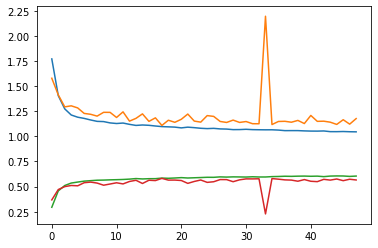

In [16]:
plt.plot(hist[:48])

In [17]:
best_acc

0.587823275862069

In [10]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_resnext_2.pt'
best_acc = 0.0
hist = []

for epoch in range(200):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc
        
#     scheduler.step()

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.241 acc: 0.180
	 - Step 2: loss: 2.016 acc: 0.133
	 - Step 3: loss: 2.133 acc: 0.172
	 - Step 4: loss: 2.031 acc: 0.203
	 - Step 5: loss: 1.921 acc: 0.172
	 - Step 6: loss: 1.906 acc: 0.250
	 - Step 7: loss: 2.128 acc: 0.234
	 - Step 8: loss: 2.124 acc: 0.211
	 - Step 9: loss: 2.047 acc: 0.219
	 - Step 10: loss: 2.099 acc: 0.180
	 - Step 11: loss: 1.943 acc: 0.141
	 - Step 12: loss: 2.102 acc: 0.195
	 - Step 13: loss: 2.011 acc: 0.227
	 - Step 14: loss: 1.941 acc: 0.195
	 - Step 15: loss: 1.894 acc: 0.266
	 - Step 16: loss: 1.863 acc: 0.281
	 - Step 17: loss: 1.890 acc: 0.234
	 - Step 18: loss: 1.922 acc: 0.242
	 - Step 19: loss: 1.902 acc: 0.234
	 - Step 20: loss: 1.989 acc: 0.203
	 - Step 21: loss: 2.029 acc: 0.273
	 - Step 22: loss: 1.889 acc: 0.242
	 - Step 23: loss: 2.031 acc: 0.211
	 - Step 24: loss: 1.977 acc: 0.195
	 - Step 25: loss: 1.912 acc: 0.188
	 - Step 26: loss: 1.989 acc: 0.242
	 - Step 27: loss: 2.040 acc: 0.211
	 - Step 28: loss: 1.841 ac

- Avg. val_loss: 1.625  | Avg. val_acc: 0.366


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVUnit. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FeatureWeight. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* Update optimal model
Epoch:  2
	 - Step 1: loss: 1.738 acc: 0.258
	 - Step 2: loss: 1.610 acc: 0.320
	 - Step 3: loss: 1.647 acc: 0.359
	 - Step 4: loss: 1.582 acc: 0.344
	 - Step 5: loss: 1.625 acc: 0.367
	 - Step 6: loss: 1.568 acc: 0.414
	 - Step 7: loss: 1.573 acc: 0.406
	 - Step 8: loss: 1.624 acc: 0.305
	 - Step 9: loss: 1.537 acc: 0.438
	 - Step 10: loss: 1.542 acc: 0.406
	 - Step 11: loss: 1.486 acc: 0.367
	 - Step 12: loss: 1.585 acc: 0.391
	 - Step 13: loss: 1.531 acc: 0.430
	 - Step 14: loss: 1.463 acc: 0.414
	 - Step 15: loss: 1.623 acc: 0.375
	 - Step 16: loss: 1.479 acc: 0.391
	 - Step 17: loss: 1.441 acc: 0.492
	 - Step 18: loss: 1.470 acc: 0.414
	 - Step 19: loss: 1.480 acc: 0.430
	 - Step 20: loss: 1.430 acc: 0.430
	 - Step 21: loss: 1.562 acc: 0.422
	 - Step 22: loss: 1.541 acc: 0.406
	 - Step 23: loss: 1.540 acc: 0.383
	 - Step 24: loss: 1.577 acc: 0.375
	 - Step 25: loss: 1.475 acc: 0.375
	 - Step 26: loss: 1.579 acc: 0.312
	 - Step 27: loss: 1.472 acc: 0.445
	 - 

	 - Step 225: loss: 1.139 acc: 0.514
- Avg.loss: 1.397  | Avg.acc: 0.462
- Avg. val_loss: 1.335  | Avg. val_acc: 0.493
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.344 acc: 0.414
	 - Step 2: loss: 1.243 acc: 0.523
	 - Step 3: loss: 1.313 acc: 0.492
	 - Step 4: loss: 1.392 acc: 0.516
	 - Step 5: loss: 1.354 acc: 0.461
	 - Step 6: loss: 1.198 acc: 0.531
	 - Step 7: loss: 1.356 acc: 0.469
	 - Step 8: loss: 1.392 acc: 0.445
	 - Step 9: loss: 1.256 acc: 0.539
	 - Step 10: loss: 1.256 acc: 0.516
	 - Step 11: loss: 1.216 acc: 0.578
	 - Step 12: loss: 1.318 acc: 0.445
	 - Step 13: loss: 1.277 acc: 0.500
	 - Step 14: loss: 1.141 acc: 0.625
	 - Step 15: loss: 1.272 acc: 0.555
	 - Step 16: loss: 1.313 acc: 0.461
	 - Step 17: loss: 1.335 acc: 0.477
	 - Step 18: loss: 1.247 acc: 0.555
	 - Step 19: loss: 1.295 acc: 0.523
	 - Step 20: loss: 1.362 acc: 0.453
	 - Step 21: loss: 1.208 acc: 0.562
	 - Step 22: loss: 1.204 acc: 0.539
	 - Step 23: loss: 1.378 acc: 0.469
	 - Step 24: loss: 1.353 acc:

	 - Step 222: loss: 1.188 acc: 0.570
	 - Step 223: loss: 1.363 acc: 0.445
	 - Step 224: loss: 1.251 acc: 0.523
	 - Step 225: loss: 1.455 acc: 0.459
- Avg.loss: 1.273  | Avg.acc: 0.514
- Avg. val_loss: 1.310  | Avg. val_acc: 0.497
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.341 acc: 0.492
	 - Step 2: loss: 1.362 acc: 0.492
	 - Step 3: loss: 1.269 acc: 0.516
	 - Step 4: loss: 1.167 acc: 0.547
	 - Step 5: loss: 1.248 acc: 0.531
	 - Step 6: loss: 1.106 acc: 0.578
	 - Step 7: loss: 1.344 acc: 0.492
	 - Step 8: loss: 1.173 acc: 0.531
	 - Step 9: loss: 1.293 acc: 0.516
	 - Step 10: loss: 1.292 acc: 0.469
	 - Step 11: loss: 1.148 acc: 0.547
	 - Step 12: loss: 1.263 acc: 0.500
	 - Step 13: loss: 1.183 acc: 0.539
	 - Step 14: loss: 1.077 acc: 0.617
	 - Step 15: loss: 1.273 acc: 0.531
	 - Step 16: loss: 1.203 acc: 0.516
	 - Step 17: loss: 1.220 acc: 0.547
	 - Step 18: loss: 1.248 acc: 0.508
	 - Step 19: loss: 1.342 acc: 0.477
	 - Step 20: loss: 1.184 acc: 0.578
	 - Step 21: loss: 1.144 a

	 - Step 219: loss: 1.263 acc: 0.547
	 - Step 220: loss: 1.147 acc: 0.578
	 - Step 221: loss: 1.261 acc: 0.531
	 - Step 222: loss: 1.147 acc: 0.555
	 - Step 223: loss: 1.108 acc: 0.562
	 - Step 224: loss: 1.293 acc: 0.531
	 - Step 225: loss: 1.430 acc: 0.432
- Avg.loss: 1.230  | Avg.acc: 0.532
- Avg. val_loss: 1.300  | Avg. val_acc: 0.500
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.109 acc: 0.562
	 - Step 2: loss: 1.273 acc: 0.516
	 - Step 3: loss: 1.177 acc: 0.547
	 - Step 4: loss: 1.273 acc: 0.523
	 - Step 5: loss: 1.332 acc: 0.469
	 - Step 6: loss: 1.227 acc: 0.531
	 - Step 7: loss: 1.144 acc: 0.578
	 - Step 8: loss: 1.225 acc: 0.492
	 - Step 9: loss: 1.258 acc: 0.562
	 - Step 10: loss: 1.151 acc: 0.539
	 - Step 11: loss: 1.316 acc: 0.500
	 - Step 12: loss: 1.135 acc: 0.578
	 - Step 13: loss: 1.087 acc: 0.547
	 - Step 14: loss: 1.146 acc: 0.555
	 - Step 15: loss: 1.159 acc: 0.562
	 - Step 16: loss: 1.355 acc: 0.531
	 - Step 17: loss: 1.393 acc: 0.438
	 - Step 18: loss: 1.39

	 - Step 216: loss: 1.393 acc: 0.438
	 - Step 217: loss: 1.239 acc: 0.516
	 - Step 218: loss: 1.206 acc: 0.531
	 - Step 219: loss: 1.170 acc: 0.547
	 - Step 220: loss: 1.413 acc: 0.430
	 - Step 221: loss: 1.152 acc: 0.531
	 - Step 222: loss: 1.208 acc: 0.531
	 - Step 223: loss: 1.219 acc: 0.594
	 - Step 224: loss: 1.217 acc: 0.523
	 - Step 225: loss: 1.262 acc: 0.514
- Avg.loss: 1.205  | Avg.acc: 0.543
- Avg. val_loss: 1.261  | Avg. val_acc: 0.518
* Update optimal model
Epoch:  6
	 - Step 1: loss: 1.155 acc: 0.594
	 - Step 2: loss: 1.112 acc: 0.633
	 - Step 3: loss: 1.314 acc: 0.531
	 - Step 4: loss: 1.080 acc: 0.672
	 - Step 5: loss: 1.221 acc: 0.578
	 - Step 6: loss: 1.003 acc: 0.648
	 - Step 7: loss: 1.306 acc: 0.516
	 - Step 8: loss: 1.193 acc: 0.594
	 - Step 9: loss: 1.212 acc: 0.531
	 - Step 10: loss: 1.128 acc: 0.547
	 - Step 11: loss: 1.142 acc: 0.578
	 - Step 12: loss: 1.198 acc: 0.523
	 - Step 13: loss: 1.080 acc: 0.586
	 - Step 14: loss: 1.107 acc: 0.578
	 - Step 15: loss: 1

	 - Step 213: loss: 1.043 acc: 0.648
	 - Step 214: loss: 1.187 acc: 0.562
	 - Step 215: loss: 1.146 acc: 0.570
	 - Step 216: loss: 1.107 acc: 0.602
	 - Step 217: loss: 1.094 acc: 0.586
	 - Step 218: loss: 1.160 acc: 0.555
	 - Step 219: loss: 1.082 acc: 0.633
	 - Step 220: loss: 1.122 acc: 0.562
	 - Step 221: loss: 1.067 acc: 0.602
	 - Step 222: loss: 1.130 acc: 0.625
	 - Step 223: loss: 1.240 acc: 0.539
	 - Step 224: loss: 1.195 acc: 0.586
	 - Step 225: loss: 1.233 acc: 0.459
- Avg.loss: 1.188  | Avg.acc: 0.551
- Avg. val_loss: 1.225  | Avg. val_acc: 0.529
* Update optimal model
Epoch:  7
	 - Step 1: loss: 1.027 acc: 0.617
	 - Step 2: loss: 1.208 acc: 0.531
	 - Step 3: loss: 1.081 acc: 0.586
	 - Step 4: loss: 1.150 acc: 0.578
	 - Step 5: loss: 1.270 acc: 0.555
	 - Step 6: loss: 1.214 acc: 0.547
	 - Step 7: loss: 0.978 acc: 0.672
	 - Step 8: loss: 1.165 acc: 0.531
	 - Step 9: loss: 1.255 acc: 0.523
	 - Step 10: loss: 1.101 acc: 0.547
	 - Step 11: loss: 1.080 acc: 0.609
	 - Step 12: loss

	 - Step 210: loss: 1.209 acc: 0.547
	 - Step 211: loss: 1.180 acc: 0.547
	 - Step 212: loss: 1.188 acc: 0.562
	 - Step 213: loss: 1.151 acc: 0.500
	 - Step 214: loss: 1.100 acc: 0.531
	 - Step 215: loss: 1.273 acc: 0.531
	 - Step 216: loss: 1.285 acc: 0.508
	 - Step 217: loss: 1.123 acc: 0.609
	 - Step 218: loss: 1.152 acc: 0.625
	 - Step 219: loss: 1.107 acc: 0.562
	 - Step 220: loss: 1.386 acc: 0.516
	 - Step 221: loss: 1.068 acc: 0.586
	 - Step 222: loss: 1.137 acc: 0.555
	 - Step 223: loss: 1.271 acc: 0.539
	 - Step 224: loss: 1.107 acc: 0.570
	 - Step 225: loss: 1.255 acc: 0.568
- Avg.loss: 1.168  | Avg.acc: 0.557
- Avg. val_loss: 1.205  | Avg. val_acc: 0.540
* Update optimal model
Epoch:  8
	 - Step 1: loss: 1.127 acc: 0.547
	 - Step 2: loss: 1.121 acc: 0.531
	 - Step 3: loss: 1.185 acc: 0.594
	 - Step 4: loss: 1.297 acc: 0.461
	 - Step 5: loss: 1.221 acc: 0.516
	 - Step 6: loss: 1.172 acc: 0.539
	 - Step 7: loss: 1.116 acc: 0.562
	 - Step 8: loss: 1.059 acc: 0.617
	 - Step 9: l

	 - Step 207: loss: 1.217 acc: 0.508
	 - Step 208: loss: 1.097 acc: 0.570
	 - Step 209: loss: 1.305 acc: 0.539
	 - Step 210: loss: 1.216 acc: 0.562
	 - Step 211: loss: 1.104 acc: 0.602
	 - Step 212: loss: 1.194 acc: 0.586
	 - Step 213: loss: 1.228 acc: 0.469
	 - Step 214: loss: 1.304 acc: 0.492
	 - Step 215: loss: 1.240 acc: 0.531
	 - Step 216: loss: 1.263 acc: 0.586
	 - Step 217: loss: 1.198 acc: 0.594
	 - Step 218: loss: 1.297 acc: 0.453
	 - Step 219: loss: 1.291 acc: 0.508
	 - Step 220: loss: 1.178 acc: 0.562
	 - Step 221: loss: 1.024 acc: 0.656
	 - Step 222: loss: 1.101 acc: 0.562
	 - Step 223: loss: 1.131 acc: 0.578
	 - Step 224: loss: 1.159 acc: 0.625
	 - Step 225: loss: 1.392 acc: 0.486
- Avg.loss: 1.165  | Avg.acc: 0.558
- Avg. val_loss: 1.194  | Avg. val_acc: 0.548
* Update optimal model
Epoch:  9
	 - Step 1: loss: 1.204 acc: 0.539
	 - Step 2: loss: 1.155 acc: 0.547
	 - Step 3: loss: 1.061 acc: 0.516
	 - Step 4: loss: 1.209 acc: 0.547
	 - Step 5: loss: 1.159 acc: 0.547
	 - Ste

	 - Step 204: loss: 1.011 acc: 0.633
	 - Step 205: loss: 1.039 acc: 0.617
	 - Step 206: loss: 1.187 acc: 0.539
	 - Step 207: loss: 1.377 acc: 0.484
	 - Step 208: loss: 1.075 acc: 0.617
	 - Step 209: loss: 1.110 acc: 0.594
	 - Step 210: loss: 1.200 acc: 0.531
	 - Step 211: loss: 1.217 acc: 0.555
	 - Step 212: loss: 1.133 acc: 0.570
	 - Step 213: loss: 1.337 acc: 0.492
	 - Step 214: loss: 1.195 acc: 0.555
	 - Step 215: loss: 1.197 acc: 0.539
	 - Step 216: loss: 1.172 acc: 0.539
	 - Step 217: loss: 1.287 acc: 0.477
	 - Step 218: loss: 1.166 acc: 0.570
	 - Step 219: loss: 1.116 acc: 0.562
	 - Step 220: loss: 1.245 acc: 0.484
	 - Step 221: loss: 1.195 acc: 0.547
	 - Step 222: loss: 1.096 acc: 0.547
	 - Step 223: loss: 1.214 acc: 0.547
	 - Step 224: loss: 1.229 acc: 0.523
	 - Step 225: loss: 0.930 acc: 0.622
- Avg.loss: 1.154  | Avg.acc: 0.563
- Avg. val_loss: 1.226  | Avg. val_acc: 0.542
Epoch:  10
	 - Step 1: loss: 1.056 acc: 0.586
	 - Step 2: loss: 1.174 acc: 0.570
	 - Step 3: loss: 1.060

	 - Step 201: loss: 1.271 acc: 0.578
	 - Step 202: loss: 1.289 acc: 0.516
	 - Step 203: loss: 1.156 acc: 0.555
	 - Step 204: loss: 1.120 acc: 0.562
	 - Step 205: loss: 1.091 acc: 0.562
	 - Step 206: loss: 1.209 acc: 0.594
	 - Step 207: loss: 1.076 acc: 0.594
	 - Step 208: loss: 1.137 acc: 0.570
	 - Step 209: loss: 1.156 acc: 0.523
	 - Step 210: loss: 1.132 acc: 0.562
	 - Step 211: loss: 1.056 acc: 0.617
	 - Step 212: loss: 1.117 acc: 0.594
	 - Step 213: loss: 1.143 acc: 0.578
	 - Step 214: loss: 1.156 acc: 0.492
	 - Step 215: loss: 1.016 acc: 0.617
	 - Step 216: loss: 1.116 acc: 0.648
	 - Step 217: loss: 1.241 acc: 0.523
	 - Step 218: loss: 1.143 acc: 0.586
	 - Step 219: loss: 1.195 acc: 0.555
	 - Step 220: loss: 1.197 acc: 0.516
	 - Step 221: loss: 0.986 acc: 0.609
	 - Step 222: loss: 1.278 acc: 0.578
	 - Step 223: loss: 1.096 acc: 0.539
	 - Step 224: loss: 1.100 acc: 0.562
	 - Step 225: loss: 1.229 acc: 0.514
- Avg.loss: 1.149  | Avg.acc: 0.568
- Avg. val_loss: 1.209  | Avg. val_acc:

	 - Step 198: loss: 1.122 acc: 0.586
	 - Step 199: loss: 1.101 acc: 0.594
	 - Step 200: loss: 1.100 acc: 0.594
	 - Step 201: loss: 1.073 acc: 0.578
	 - Step 202: loss: 0.994 acc: 0.688
	 - Step 203: loss: 1.080 acc: 0.602
	 - Step 204: loss: 1.123 acc: 0.523
	 - Step 205: loss: 1.027 acc: 0.602
	 - Step 206: loss: 1.318 acc: 0.516
	 - Step 207: loss: 1.240 acc: 0.484
	 - Step 208: loss: 1.207 acc: 0.523
	 - Step 209: loss: 1.292 acc: 0.516
	 - Step 210: loss: 1.252 acc: 0.516
	 - Step 211: loss: 1.093 acc: 0.555
	 - Step 212: loss: 1.225 acc: 0.586
	 - Step 213: loss: 1.099 acc: 0.578
	 - Step 214: loss: 1.100 acc: 0.617
	 - Step 215: loss: 1.088 acc: 0.578
	 - Step 216: loss: 1.258 acc: 0.477
	 - Step 217: loss: 1.104 acc: 0.570
	 - Step 218: loss: 1.141 acc: 0.602
	 - Step 219: loss: 1.030 acc: 0.664
	 - Step 220: loss: 1.043 acc: 0.625
	 - Step 221: loss: 1.120 acc: 0.625
	 - Step 222: loss: 1.133 acc: 0.555
	 - Step 223: loss: 1.184 acc: 0.570
	 - Step 224: loss: 1.069 acc: 0.562
	

	 - Step 195: loss: 1.200 acc: 0.555
	 - Step 196: loss: 1.226 acc: 0.539
	 - Step 197: loss: 1.175 acc: 0.531
	 - Step 198: loss: 1.209 acc: 0.508
	 - Step 199: loss: 1.132 acc: 0.547
	 - Step 200: loss: 1.036 acc: 0.609
	 - Step 201: loss: 1.142 acc: 0.547
	 - Step 202: loss: 1.047 acc: 0.609
	 - Step 203: loss: 1.167 acc: 0.570
	 - Step 204: loss: 1.193 acc: 0.562
	 - Step 205: loss: 1.200 acc: 0.547
	 - Step 206: loss: 1.195 acc: 0.539
	 - Step 207: loss: 1.117 acc: 0.609
	 - Step 208: loss: 1.219 acc: 0.562
	 - Step 209: loss: 1.116 acc: 0.539
	 - Step 210: loss: 1.170 acc: 0.617
	 - Step 211: loss: 1.136 acc: 0.586
	 - Step 212: loss: 1.267 acc: 0.484
	 - Step 213: loss: 1.041 acc: 0.672
	 - Step 214: loss: 1.072 acc: 0.617
	 - Step 215: loss: 1.356 acc: 0.508
	 - Step 216: loss: 1.169 acc: 0.547
	 - Step 217: loss: 1.311 acc: 0.508
	 - Step 218: loss: 1.011 acc: 0.609
	 - Step 219: loss: 1.202 acc: 0.531
	 - Step 220: loss: 1.120 acc: 0.609
	 - Step 221: loss: 1.133 acc: 0.570
	

	 - Step 192: loss: 1.034 acc: 0.570
	 - Step 193: loss: 1.331 acc: 0.461
	 - Step 194: loss: 1.342 acc: 0.500
	 - Step 195: loss: 1.293 acc: 0.516
	 - Step 196: loss: 1.153 acc: 0.539
	 - Step 197: loss: 1.241 acc: 0.469
	 - Step 198: loss: 1.121 acc: 0.594
	 - Step 199: loss: 1.357 acc: 0.484
	 - Step 200: loss: 1.169 acc: 0.539
	 - Step 201: loss: 1.073 acc: 0.594
	 - Step 202: loss: 1.178 acc: 0.539
	 - Step 203: loss: 1.238 acc: 0.516
	 - Step 204: loss: 1.168 acc: 0.570
	 - Step 205: loss: 1.127 acc: 0.531
	 - Step 206: loss: 1.041 acc: 0.586
	 - Step 207: loss: 1.096 acc: 0.617
	 - Step 208: loss: 1.062 acc: 0.625
	 - Step 209: loss: 1.182 acc: 0.547
	 - Step 210: loss: 1.110 acc: 0.523
	 - Step 211: loss: 1.166 acc: 0.555
	 - Step 212: loss: 1.344 acc: 0.523
	 - Step 213: loss: 1.073 acc: 0.562
	 - Step 214: loss: 1.141 acc: 0.570
	 - Step 215: loss: 1.227 acc: 0.484
	 - Step 216: loss: 1.158 acc: 0.523
	 - Step 217: loss: 1.299 acc: 0.516
	 - Step 218: loss: 1.233 acc: 0.547
	

	 - Step 189: loss: 1.166 acc: 0.539
	 - Step 190: loss: 1.024 acc: 0.656
	 - Step 191: loss: 1.085 acc: 0.633
	 - Step 192: loss: 1.002 acc: 0.641
	 - Step 193: loss: 1.137 acc: 0.562
	 - Step 194: loss: 1.142 acc: 0.586
	 - Step 195: loss: 1.170 acc: 0.562
	 - Step 196: loss: 1.227 acc: 0.484
	 - Step 197: loss: 1.141 acc: 0.531
	 - Step 198: loss: 1.059 acc: 0.625
	 - Step 199: loss: 1.139 acc: 0.594
	 - Step 200: loss: 1.104 acc: 0.594
	 - Step 201: loss: 1.187 acc: 0.539
	 - Step 202: loss: 1.078 acc: 0.570
	 - Step 203: loss: 1.173 acc: 0.531
	 - Step 204: loss: 1.115 acc: 0.570
	 - Step 205: loss: 1.235 acc: 0.516
	 - Step 206: loss: 1.086 acc: 0.602
	 - Step 207: loss: 1.277 acc: 0.516
	 - Step 208: loss: 0.969 acc: 0.656
	 - Step 209: loss: 1.056 acc: 0.609
	 - Step 210: loss: 1.059 acc: 0.633
	 - Step 211: loss: 1.117 acc: 0.570
	 - Step 212: loss: 0.956 acc: 0.617
	 - Step 213: loss: 1.085 acc: 0.547
	 - Step 214: loss: 1.015 acc: 0.570
	 - Step 215: loss: 1.227 acc: 0.523
	

	 - Step 186: loss: 1.163 acc: 0.531
	 - Step 187: loss: 1.022 acc: 0.617
	 - Step 188: loss: 1.108 acc: 0.586
	 - Step 189: loss: 1.051 acc: 0.609
	 - Step 190: loss: 1.185 acc: 0.523
	 - Step 191: loss: 1.087 acc: 0.578
	 - Step 192: loss: 1.160 acc: 0.602
	 - Step 193: loss: 1.099 acc: 0.578
	 - Step 194: loss: 1.130 acc: 0.547
	 - Step 195: loss: 1.160 acc: 0.523
	 - Step 196: loss: 0.993 acc: 0.641
	 - Step 197: loss: 1.225 acc: 0.562
	 - Step 198: loss: 1.158 acc: 0.609
	 - Step 199: loss: 1.054 acc: 0.625
	 - Step 200: loss: 1.002 acc: 0.594
	 - Step 201: loss: 1.103 acc: 0.633
	 - Step 202: loss: 1.076 acc: 0.602
	 - Step 203: loss: 1.075 acc: 0.609
	 - Step 204: loss: 1.098 acc: 0.625
	 - Step 205: loss: 1.060 acc: 0.570
	 - Step 206: loss: 1.040 acc: 0.617
	 - Step 207: loss: 1.129 acc: 0.602
	 - Step 208: loss: 1.177 acc: 0.547
	 - Step 209: loss: 1.161 acc: 0.570
	 - Step 210: loss: 1.159 acc: 0.586
	 - Step 211: loss: 1.069 acc: 0.578
	 - Step 212: loss: 1.248 acc: 0.547
	

	 - Step 183: loss: 1.181 acc: 0.555
	 - Step 184: loss: 1.032 acc: 0.570
	 - Step 185: loss: 1.172 acc: 0.555
	 - Step 186: loss: 1.038 acc: 0.617
	 - Step 187: loss: 1.159 acc: 0.594
	 - Step 188: loss: 1.083 acc: 0.602
	 - Step 189: loss: 1.120 acc: 0.555
	 - Step 190: loss: 1.039 acc: 0.617
	 - Step 191: loss: 1.050 acc: 0.625
	 - Step 192: loss: 1.022 acc: 0.617
	 - Step 193: loss: 1.135 acc: 0.594
	 - Step 194: loss: 1.220 acc: 0.547
	 - Step 195: loss: 1.087 acc: 0.555
	 - Step 196: loss: 1.100 acc: 0.609
	 - Step 197: loss: 1.044 acc: 0.617
	 - Step 198: loss: 1.085 acc: 0.633
	 - Step 199: loss: 1.050 acc: 0.609
	 - Step 200: loss: 1.133 acc: 0.562
	 - Step 201: loss: 1.049 acc: 0.617
	 - Step 202: loss: 1.175 acc: 0.555
	 - Step 203: loss: 1.155 acc: 0.602
	 - Step 204: loss: 0.960 acc: 0.672
	 - Step 205: loss: 1.161 acc: 0.570
	 - Step 206: loss: 1.283 acc: 0.523
	 - Step 207: loss: 1.106 acc: 0.617
	 - Step 208: loss: 1.285 acc: 0.484
	 - Step 209: loss: 1.266 acc: 0.594
	

	 - Step 180: loss: 1.175 acc: 0.508
	 - Step 181: loss: 1.130 acc: 0.562
	 - Step 182: loss: 1.048 acc: 0.555
	 - Step 183: loss: 1.156 acc: 0.586
	 - Step 184: loss: 1.018 acc: 0.609
	 - Step 185: loss: 1.062 acc: 0.617
	 - Step 186: loss: 1.190 acc: 0.531
	 - Step 187: loss: 1.172 acc: 0.523
	 - Step 188: loss: 1.200 acc: 0.523
	 - Step 189: loss: 1.215 acc: 0.562
	 - Step 190: loss: 1.222 acc: 0.594
	 - Step 191: loss: 1.233 acc: 0.531
	 - Step 192: loss: 1.141 acc: 0.562
	 - Step 193: loss: 1.134 acc: 0.594
	 - Step 194: loss: 1.095 acc: 0.602
	 - Step 195: loss: 1.302 acc: 0.477
	 - Step 196: loss: 1.083 acc: 0.555
	 - Step 197: loss: 1.131 acc: 0.602
	 - Step 198: loss: 1.212 acc: 0.516
	 - Step 199: loss: 1.168 acc: 0.555
	 - Step 200: loss: 1.151 acc: 0.547
	 - Step 201: loss: 1.150 acc: 0.555
	 - Step 202: loss: 1.210 acc: 0.453
	 - Step 203: loss: 1.186 acc: 0.578
	 - Step 204: loss: 1.128 acc: 0.602
	 - Step 205: loss: 1.160 acc: 0.586
	 - Step 206: loss: 1.122 acc: 0.555
	

	 - Step 177: loss: 1.070 acc: 0.547
	 - Step 178: loss: 1.255 acc: 0.555
	 - Step 179: loss: 1.153 acc: 0.586
	 - Step 180: loss: 1.209 acc: 0.539
	 - Step 181: loss: 1.115 acc: 0.562
	 - Step 182: loss: 1.161 acc: 0.594
	 - Step 183: loss: 0.982 acc: 0.609
	 - Step 184: loss: 1.104 acc: 0.594
	 - Step 185: loss: 1.020 acc: 0.602
	 - Step 186: loss: 1.063 acc: 0.609
	 - Step 187: loss: 1.255 acc: 0.516
	 - Step 188: loss: 1.265 acc: 0.531
	 - Step 189: loss: 1.147 acc: 0.594
	 - Step 190: loss: 1.065 acc: 0.625
	 - Step 191: loss: 1.009 acc: 0.625
	 - Step 192: loss: 1.274 acc: 0.516
	 - Step 193: loss: 1.003 acc: 0.625
	 - Step 194: loss: 1.030 acc: 0.617
	 - Step 195: loss: 1.193 acc: 0.562
	 - Step 196: loss: 1.162 acc: 0.523
	 - Step 197: loss: 1.075 acc: 0.547
	 - Step 198: loss: 1.158 acc: 0.531
	 - Step 199: loss: 1.202 acc: 0.523
	 - Step 200: loss: 1.188 acc: 0.516
	 - Step 201: loss: 1.295 acc: 0.523
	 - Step 202: loss: 1.157 acc: 0.617
	 - Step 203: loss: 0.976 acc: 0.680
	

	 - Step 174: loss: 1.126 acc: 0.578
	 - Step 175: loss: 1.164 acc: 0.578
	 - Step 176: loss: 1.075 acc: 0.562
	 - Step 177: loss: 1.057 acc: 0.586
	 - Step 178: loss: 1.014 acc: 0.602
	 - Step 179: loss: 1.070 acc: 0.602
	 - Step 180: loss: 1.158 acc: 0.562
	 - Step 181: loss: 1.202 acc: 0.539
	 - Step 182: loss: 1.137 acc: 0.570
	 - Step 183: loss: 1.055 acc: 0.617
	 - Step 184: loss: 1.188 acc: 0.562
	 - Step 185: loss: 1.372 acc: 0.539
	 - Step 186: loss: 1.111 acc: 0.617
	 - Step 187: loss: 1.134 acc: 0.570
	 - Step 188: loss: 1.229 acc: 0.547
	 - Step 189: loss: 1.219 acc: 0.508
	 - Step 190: loss: 1.159 acc: 0.602
	 - Step 191: loss: 1.199 acc: 0.555
	 - Step 192: loss: 1.152 acc: 0.570
	 - Step 193: loss: 1.191 acc: 0.570
	 - Step 194: loss: 1.028 acc: 0.602
	 - Step 195: loss: 1.125 acc: 0.617
	 - Step 196: loss: 1.105 acc: 0.586
	 - Step 197: loss: 1.070 acc: 0.594
	 - Step 198: loss: 1.153 acc: 0.523
	 - Step 199: loss: 1.218 acc: 0.523
	 - Step 200: loss: 1.125 acc: 0.562
	

	 - Step 171: loss: 1.028 acc: 0.602
	 - Step 172: loss: 1.169 acc: 0.555
	 - Step 173: loss: 1.197 acc: 0.586
	 - Step 174: loss: 1.238 acc: 0.539
	 - Step 175: loss: 1.333 acc: 0.508
	 - Step 176: loss: 1.099 acc: 0.562
	 - Step 177: loss: 1.147 acc: 0.609
	 - Step 178: loss: 1.090 acc: 0.570
	 - Step 179: loss: 1.192 acc: 0.547
	 - Step 180: loss: 1.166 acc: 0.578
	 - Step 181: loss: 1.181 acc: 0.500
	 - Step 182: loss: 1.162 acc: 0.547
	 - Step 183: loss: 1.081 acc: 0.633
	 - Step 184: loss: 1.081 acc: 0.562
	 - Step 185: loss: 1.108 acc: 0.578
	 - Step 186: loss: 1.173 acc: 0.570
	 - Step 187: loss: 1.107 acc: 0.625
	 - Step 188: loss: 0.945 acc: 0.695
	 - Step 189: loss: 1.033 acc: 0.609
	 - Step 190: loss: 1.083 acc: 0.578
	 - Step 191: loss: 1.167 acc: 0.555
	 - Step 192: loss: 1.148 acc: 0.609
	 - Step 193: loss: 1.094 acc: 0.555
	 - Step 194: loss: 1.136 acc: 0.547
	 - Step 195: loss: 1.138 acc: 0.586
	 - Step 196: loss: 1.172 acc: 0.539
	 - Step 197: loss: 1.115 acc: 0.586
	

	 - Step 168: loss: 0.991 acc: 0.602
	 - Step 169: loss: 0.942 acc: 0.648
	 - Step 170: loss: 1.099 acc: 0.578
	 - Step 171: loss: 1.138 acc: 0.570
	 - Step 172: loss: 1.041 acc: 0.578
	 - Step 173: loss: 1.225 acc: 0.531
	 - Step 174: loss: 0.968 acc: 0.648
	 - Step 175: loss: 1.115 acc: 0.570
	 - Step 176: loss: 1.293 acc: 0.523
	 - Step 177: loss: 1.108 acc: 0.586
	 - Step 178: loss: 1.149 acc: 0.609
	 - Step 179: loss: 1.114 acc: 0.562
	 - Step 180: loss: 0.994 acc: 0.625
	 - Step 181: loss: 1.136 acc: 0.539
	 - Step 182: loss: 1.095 acc: 0.609
	 - Step 183: loss: 1.090 acc: 0.562
	 - Step 184: loss: 1.070 acc: 0.555
	 - Step 185: loss: 1.129 acc: 0.609
	 - Step 186: loss: 1.184 acc: 0.602
	 - Step 187: loss: 0.977 acc: 0.688
	 - Step 188: loss: 0.963 acc: 0.633
	 - Step 189: loss: 0.957 acc: 0.633
	 - Step 190: loss: 1.140 acc: 0.555
	 - Step 191: loss: 1.096 acc: 0.586
	 - Step 192: loss: 1.020 acc: 0.656
	 - Step 193: loss: 1.247 acc: 0.547
	 - Step 194: loss: 1.270 acc: 0.531
	

	 - Step 165: loss: 1.215 acc: 0.516
	 - Step 166: loss: 1.043 acc: 0.648
	 - Step 167: loss: 0.970 acc: 0.648
	 - Step 168: loss: 1.146 acc: 0.539
	 - Step 169: loss: 1.158 acc: 0.555
	 - Step 170: loss: 1.042 acc: 0.586
	 - Step 171: loss: 1.022 acc: 0.625
	 - Step 172: loss: 1.131 acc: 0.570
	 - Step 173: loss: 1.094 acc: 0.602
	 - Step 174: loss: 1.169 acc: 0.570
	 - Step 175: loss: 0.972 acc: 0.641
	 - Step 176: loss: 1.094 acc: 0.617
	 - Step 177: loss: 1.128 acc: 0.570
	 - Step 178: loss: 1.138 acc: 0.570
	 - Step 179: loss: 1.029 acc: 0.617
	 - Step 180: loss: 1.091 acc: 0.602
	 - Step 181: loss: 1.256 acc: 0.508
	 - Step 182: loss: 1.163 acc: 0.555
	 - Step 183: loss: 1.096 acc: 0.609
	 - Step 184: loss: 1.272 acc: 0.539
	 - Step 185: loss: 1.070 acc: 0.617
	 - Step 186: loss: 1.059 acc: 0.555
	 - Step 187: loss: 1.172 acc: 0.547
	 - Step 188: loss: 1.061 acc: 0.602
	 - Step 189: loss: 1.164 acc: 0.555
	 - Step 190: loss: 1.181 acc: 0.578
	 - Step 191: loss: 1.115 acc: 0.547
	

	 - Step 162: loss: 1.060 acc: 0.609
	 - Step 163: loss: 1.045 acc: 0.625
	 - Step 164: loss: 1.034 acc: 0.594
	 - Step 165: loss: 1.052 acc: 0.602
	 - Step 166: loss: 1.284 acc: 0.531
	 - Step 167: loss: 1.097 acc: 0.562
	 - Step 168: loss: 1.044 acc: 0.602
	 - Step 169: loss: 1.206 acc: 0.508
	 - Step 170: loss: 1.068 acc: 0.656
	 - Step 171: loss: 1.199 acc: 0.578
	 - Step 172: loss: 1.111 acc: 0.523
	 - Step 173: loss: 1.136 acc: 0.570
	 - Step 174: loss: 1.004 acc: 0.609
	 - Step 175: loss: 1.146 acc: 0.562
	 - Step 176: loss: 1.048 acc: 0.625
	 - Step 177: loss: 1.201 acc: 0.523
	 - Step 178: loss: 1.176 acc: 0.570
	 - Step 179: loss: 1.209 acc: 0.500
	 - Step 180: loss: 1.121 acc: 0.594
	 - Step 181: loss: 1.146 acc: 0.578
	 - Step 182: loss: 1.018 acc: 0.625
	 - Step 183: loss: 0.902 acc: 0.695
	 - Step 184: loss: 1.023 acc: 0.633
	 - Step 185: loss: 1.056 acc: 0.688
	 - Step 186: loss: 1.290 acc: 0.516
	 - Step 187: loss: 1.026 acc: 0.648
	 - Step 188: loss: 1.079 acc: 0.586
	

	 - Step 159: loss: 1.095 acc: 0.625
	 - Step 160: loss: 1.117 acc: 0.594
	 - Step 161: loss: 1.033 acc: 0.586
	 - Step 162: loss: 1.171 acc: 0.562
	 - Step 163: loss: 1.150 acc: 0.570
	 - Step 164: loss: 1.033 acc: 0.625
	 - Step 165: loss: 1.220 acc: 0.562
	 - Step 166: loss: 1.208 acc: 0.531
	 - Step 167: loss: 1.021 acc: 0.617
	 - Step 168: loss: 1.037 acc: 0.617
	 - Step 169: loss: 1.085 acc: 0.570
	 - Step 170: loss: 1.052 acc: 0.609
	 - Step 171: loss: 1.172 acc: 0.531
	 - Step 172: loss: 1.131 acc: 0.602
	 - Step 173: loss: 1.085 acc: 0.594
	 - Step 174: loss: 1.164 acc: 0.594
	 - Step 175: loss: 1.296 acc: 0.492
	 - Step 176: loss: 1.087 acc: 0.562
	 - Step 177: loss: 1.057 acc: 0.602
	 - Step 178: loss: 1.112 acc: 0.578
	 - Step 179: loss: 1.182 acc: 0.516
	 - Step 180: loss: 0.960 acc: 0.609
	 - Step 181: loss: 1.173 acc: 0.570
	 - Step 182: loss: 0.929 acc: 0.656
	 - Step 183: loss: 1.151 acc: 0.539
	 - Step 184: loss: 1.021 acc: 0.602
	 - Step 185: loss: 1.070 acc: 0.641
	

	 - Step 156: loss: 1.160 acc: 0.586
	 - Step 157: loss: 1.062 acc: 0.609
	 - Step 158: loss: 1.145 acc: 0.516
	 - Step 159: loss: 1.079 acc: 0.609
	 - Step 160: loss: 1.124 acc: 0.594
	 - Step 161: loss: 1.105 acc: 0.562
	 - Step 162: loss: 1.193 acc: 0.555
	 - Step 163: loss: 1.015 acc: 0.570
	 - Step 164: loss: 1.163 acc: 0.508
	 - Step 165: loss: 1.067 acc: 0.602
	 - Step 166: loss: 1.125 acc: 0.570
	 - Step 167: loss: 1.060 acc: 0.562
	 - Step 168: loss: 1.195 acc: 0.547
	 - Step 169: loss: 1.332 acc: 0.500
	 - Step 170: loss: 1.131 acc: 0.562
	 - Step 171: loss: 1.014 acc: 0.609
	 - Step 172: loss: 1.044 acc: 0.602
	 - Step 173: loss: 1.137 acc: 0.547
	 - Step 174: loss: 0.995 acc: 0.641
	 - Step 175: loss: 0.981 acc: 0.641
	 - Step 176: loss: 1.094 acc: 0.617
	 - Step 177: loss: 1.122 acc: 0.617
	 - Step 178: loss: 1.059 acc: 0.602
	 - Step 179: loss: 1.089 acc: 0.617
	 - Step 180: loss: 1.289 acc: 0.531
	 - Step 181: loss: 1.108 acc: 0.609
	 - Step 182: loss: 1.165 acc: 0.570
	

	 - Step 153: loss: 0.999 acc: 0.633
	 - Step 154: loss: 1.016 acc: 0.594
	 - Step 155: loss: 1.168 acc: 0.555
	 - Step 156: loss: 1.140 acc: 0.555
	 - Step 157: loss: 1.285 acc: 0.578
	 - Step 158: loss: 1.095 acc: 0.586
	 - Step 159: loss: 1.062 acc: 0.586
	 - Step 160: loss: 1.192 acc: 0.516
	 - Step 161: loss: 1.222 acc: 0.539
	 - Step 162: loss: 0.966 acc: 0.625
	 - Step 163: loss: 1.049 acc: 0.609
	 - Step 164: loss: 1.100 acc: 0.531
	 - Step 165: loss: 1.037 acc: 0.602
	 - Step 166: loss: 1.153 acc: 0.539
	 - Step 167: loss: 1.013 acc: 0.594
	 - Step 168: loss: 1.112 acc: 0.586
	 - Step 169: loss: 1.008 acc: 0.602
	 - Step 170: loss: 1.152 acc: 0.570
	 - Step 171: loss: 1.098 acc: 0.562
	 - Step 172: loss: 1.059 acc: 0.570
	 - Step 173: loss: 1.090 acc: 0.617
	 - Step 174: loss: 1.114 acc: 0.562
	 - Step 175: loss: 1.101 acc: 0.609
	 - Step 176: loss: 1.007 acc: 0.672
	 - Step 177: loss: 1.133 acc: 0.594
	 - Step 178: loss: 1.115 acc: 0.633
	 - Step 179: loss: 1.025 acc: 0.586
	

	 - Step 150: loss: 1.071 acc: 0.617
	 - Step 151: loss: 1.318 acc: 0.508
	 - Step 152: loss: 1.038 acc: 0.648
	 - Step 153: loss: 1.126 acc: 0.594
	 - Step 154: loss: 1.241 acc: 0.547
	 - Step 155: loss: 1.136 acc: 0.555
	 - Step 156: loss: 1.041 acc: 0.602
	 - Step 157: loss: 0.917 acc: 0.664
	 - Step 158: loss: 1.055 acc: 0.594
	 - Step 159: loss: 1.132 acc: 0.562
	 - Step 160: loss: 1.119 acc: 0.555
	 - Step 161: loss: 1.135 acc: 0.562
	 - Step 162: loss: 1.234 acc: 0.516
	 - Step 163: loss: 1.092 acc: 0.602
	 - Step 164: loss: 1.055 acc: 0.594
	 - Step 165: loss: 1.087 acc: 0.625
	 - Step 166: loss: 1.162 acc: 0.555
	 - Step 167: loss: 1.151 acc: 0.562
	 - Step 168: loss: 1.066 acc: 0.570
	 - Step 169: loss: 1.163 acc: 0.539
	 - Step 170: loss: 1.073 acc: 0.539
	 - Step 171: loss: 1.180 acc: 0.586
	 - Step 172: loss: 1.170 acc: 0.602
	 - Step 173: loss: 1.145 acc: 0.555
	 - Step 174: loss: 1.102 acc: 0.578
	 - Step 175: loss: 1.136 acc: 0.609
	 - Step 176: loss: 1.148 acc: 0.602
	

	 - Step 147: loss: 1.011 acc: 0.625
	 - Step 148: loss: 1.039 acc: 0.586
	 - Step 149: loss: 1.058 acc: 0.602
	 - Step 150: loss: 1.166 acc: 0.531
	 - Step 151: loss: 0.994 acc: 0.664
	 - Step 152: loss: 1.087 acc: 0.633
	 - Step 153: loss: 1.105 acc: 0.570
	 - Step 154: loss: 1.114 acc: 0.586
	 - Step 155: loss: 1.058 acc: 0.562
	 - Step 156: loss: 0.991 acc: 0.656
	 - Step 157: loss: 1.201 acc: 0.555
	 - Step 158: loss: 1.003 acc: 0.625
	 - Step 159: loss: 1.186 acc: 0.562
	 - Step 160: loss: 1.177 acc: 0.594
	 - Step 161: loss: 1.201 acc: 0.516
	 - Step 162: loss: 1.119 acc: 0.586
	 - Step 163: loss: 1.344 acc: 0.492
	 - Step 164: loss: 1.039 acc: 0.602
	 - Step 165: loss: 0.952 acc: 0.680
	 - Step 166: loss: 1.040 acc: 0.625
	 - Step 167: loss: 1.077 acc: 0.594
	 - Step 168: loss: 1.125 acc: 0.555
	 - Step 169: loss: 1.128 acc: 0.570
	 - Step 170: loss: 1.149 acc: 0.633
	 - Step 171: loss: 1.097 acc: 0.602
	 - Step 172: loss: 1.028 acc: 0.609
	 - Step 173: loss: 1.218 acc: 0.523
	

	 - Step 144: loss: 1.113 acc: 0.562
	 - Step 145: loss: 1.058 acc: 0.578
	 - Step 146: loss: 1.047 acc: 0.625
	 - Step 147: loss: 1.091 acc: 0.578
	 - Step 148: loss: 1.124 acc: 0.570
	 - Step 149: loss: 0.968 acc: 0.594
	 - Step 150: loss: 0.980 acc: 0.672
	 - Step 151: loss: 1.101 acc: 0.547
	 - Step 152: loss: 1.071 acc: 0.609
	 - Step 153: loss: 1.063 acc: 0.555
	 - Step 154: loss: 0.947 acc: 0.648
	 - Step 155: loss: 1.261 acc: 0.547
	 - Step 156: loss: 1.023 acc: 0.578
	 - Step 157: loss: 1.003 acc: 0.648
	 - Step 158: loss: 1.121 acc: 0.555
	 - Step 159: loss: 1.047 acc: 0.578
	 - Step 160: loss: 1.004 acc: 0.602
	 - Step 161: loss: 1.033 acc: 0.617
	 - Step 162: loss: 1.227 acc: 0.547
	 - Step 163: loss: 1.109 acc: 0.523
	 - Step 164: loss: 1.117 acc: 0.562
	 - Step 165: loss: 1.299 acc: 0.430
	 - Step 166: loss: 1.110 acc: 0.516
	 - Step 167: loss: 1.197 acc: 0.562
	 - Step 168: loss: 0.945 acc: 0.633
	 - Step 169: loss: 1.209 acc: 0.562
	 - Step 170: loss: 1.176 acc: 0.531
	

	 - Step 141: loss: 1.033 acc: 0.625
	 - Step 142: loss: 1.000 acc: 0.617
	 - Step 143: loss: 1.096 acc: 0.609
	 - Step 144: loss: 1.180 acc: 0.570
	 - Step 145: loss: 0.959 acc: 0.703
	 - Step 146: loss: 1.162 acc: 0.547
	 - Step 147: loss: 1.177 acc: 0.547
	 - Step 148: loss: 1.142 acc: 0.516
	 - Step 149: loss: 1.037 acc: 0.617
	 - Step 150: loss: 1.276 acc: 0.516
	 - Step 151: loss: 1.128 acc: 0.617
	 - Step 152: loss: 1.156 acc: 0.609
	 - Step 153: loss: 0.974 acc: 0.609
	 - Step 154: loss: 0.946 acc: 0.633
	 - Step 155: loss: 1.243 acc: 0.539
	 - Step 156: loss: 0.990 acc: 0.664
	 - Step 157: loss: 0.993 acc: 0.617
	 - Step 158: loss: 0.810 acc: 0.719
	 - Step 159: loss: 1.102 acc: 0.547
	 - Step 160: loss: 1.073 acc: 0.562
	 - Step 161: loss: 1.129 acc: 0.594
	 - Step 162: loss: 1.337 acc: 0.539
	 - Step 163: loss: 1.128 acc: 0.539
	 - Step 164: loss: 1.096 acc: 0.594
	 - Step 165: loss: 0.873 acc: 0.656
	 - Step 166: loss: 0.975 acc: 0.672
	 - Step 167: loss: 1.207 acc: 0.508
	

	 - Step 138: loss: 1.111 acc: 0.617
	 - Step 139: loss: 1.271 acc: 0.570
	 - Step 140: loss: 1.146 acc: 0.547
	 - Step 141: loss: 1.058 acc: 0.594
	 - Step 142: loss: 1.027 acc: 0.578
	 - Step 143: loss: 1.114 acc: 0.555
	 - Step 144: loss: 1.175 acc: 0.539
	 - Step 145: loss: 1.076 acc: 0.602
	 - Step 146: loss: 1.093 acc: 0.578
	 - Step 147: loss: 1.030 acc: 0.641
	 - Step 148: loss: 1.168 acc: 0.531
	 - Step 149: loss: 1.128 acc: 0.547
	 - Step 150: loss: 1.102 acc: 0.586
	 - Step 151: loss: 1.116 acc: 0.594
	 - Step 152: loss: 1.002 acc: 0.609
	 - Step 153: loss: 1.014 acc: 0.625
	 - Step 154: loss: 1.210 acc: 0.555
	 - Step 155: loss: 1.139 acc: 0.500
	 - Step 156: loss: 1.117 acc: 0.555
	 - Step 157: loss: 1.195 acc: 0.531
	 - Step 158: loss: 1.010 acc: 0.602
	 - Step 159: loss: 1.116 acc: 0.547
	 - Step 160: loss: 1.116 acc: 0.539
	 - Step 161: loss: 1.218 acc: 0.555
	 - Step 162: loss: 1.052 acc: 0.609
	 - Step 163: loss: 1.261 acc: 0.562
	 - Step 164: loss: 1.117 acc: 0.562
	

	 - Step 135: loss: 1.110 acc: 0.562
	 - Step 136: loss: 1.107 acc: 0.586
	 - Step 137: loss: 1.022 acc: 0.656
	 - Step 138: loss: 1.169 acc: 0.602
	 - Step 139: loss: 1.095 acc: 0.578
	 - Step 140: loss: 1.031 acc: 0.633
	 - Step 141: loss: 0.952 acc: 0.648
	 - Step 142: loss: 1.159 acc: 0.578
	 - Step 143: loss: 1.160 acc: 0.531
	 - Step 144: loss: 1.079 acc: 0.617
	 - Step 145: loss: 1.106 acc: 0.555
	 - Step 146: loss: 1.018 acc: 0.641
	 - Step 147: loss: 1.154 acc: 0.578
	 - Step 148: loss: 0.963 acc: 0.672
	 - Step 149: loss: 0.922 acc: 0.695
	 - Step 150: loss: 0.986 acc: 0.586
	 - Step 151: loss: 1.236 acc: 0.562
	 - Step 152: loss: 1.040 acc: 0.633
	 - Step 153: loss: 1.194 acc: 0.555
	 - Step 154: loss: 1.126 acc: 0.531
	 - Step 155: loss: 1.051 acc: 0.625
	 - Step 156: loss: 1.281 acc: 0.492
	 - Step 157: loss: 1.042 acc: 0.609
	 - Step 158: loss: 0.954 acc: 0.664
	 - Step 159: loss: 1.146 acc: 0.547
	 - Step 160: loss: 1.016 acc: 0.656
	 - Step 161: loss: 1.071 acc: 0.594
	

	 - Step 132: loss: 1.124 acc: 0.570
	 - Step 133: loss: 1.201 acc: 0.516
	 - Step 134: loss: 1.158 acc: 0.555
	 - Step 135: loss: 1.104 acc: 0.555
	 - Step 136: loss: 1.312 acc: 0.531
	 - Step 137: loss: 1.014 acc: 0.609
	 - Step 138: loss: 1.128 acc: 0.547
	 - Step 139: loss: 1.129 acc: 0.539
	 - Step 140: loss: 0.944 acc: 0.656
	 - Step 141: loss: 1.085 acc: 0.555
	 - Step 142: loss: 1.175 acc: 0.516
	 - Step 143: loss: 1.051 acc: 0.586
	 - Step 144: loss: 1.062 acc: 0.602
	 - Step 145: loss: 1.043 acc: 0.609
	 - Step 146: loss: 1.142 acc: 0.578
	 - Step 147: loss: 1.025 acc: 0.656
	 - Step 148: loss: 1.040 acc: 0.586
	 - Step 149: loss: 0.997 acc: 0.594
	 - Step 150: loss: 1.069 acc: 0.625
	 - Step 151: loss: 1.059 acc: 0.602
	 - Step 152: loss: 0.975 acc: 0.648
	 - Step 153: loss: 1.012 acc: 0.648
	 - Step 154: loss: 1.076 acc: 0.578
	 - Step 155: loss: 1.112 acc: 0.555
	 - Step 156: loss: 1.076 acc: 0.555
	 - Step 157: loss: 1.166 acc: 0.531
	 - Step 158: loss: 0.997 acc: 0.672
	

	 - Step 129: loss: 0.991 acc: 0.617
	 - Step 130: loss: 1.059 acc: 0.648
	 - Step 131: loss: 1.057 acc: 0.594
	 - Step 132: loss: 1.061 acc: 0.594
	 - Step 133: loss: 1.131 acc: 0.570
	 - Step 134: loss: 1.178 acc: 0.562
	 - Step 135: loss: 1.169 acc: 0.570
	 - Step 136: loss: 1.174 acc: 0.523
	 - Step 137: loss: 1.156 acc: 0.586
	 - Step 138: loss: 1.026 acc: 0.602
	 - Step 139: loss: 1.106 acc: 0.586
	 - Step 140: loss: 1.198 acc: 0.594
	 - Step 141: loss: 1.216 acc: 0.570
	 - Step 142: loss: 1.088 acc: 0.555
	 - Step 143: loss: 1.093 acc: 0.617
	 - Step 144: loss: 1.119 acc: 0.547
	 - Step 145: loss: 1.255 acc: 0.516
	 - Step 146: loss: 1.141 acc: 0.602
	 - Step 147: loss: 1.133 acc: 0.531
	 - Step 148: loss: 0.918 acc: 0.664
	 - Step 149: loss: 0.998 acc: 0.586
	 - Step 150: loss: 1.164 acc: 0.562
	 - Step 151: loss: 1.039 acc: 0.594
	 - Step 152: loss: 1.126 acc: 0.586
	 - Step 153: loss: 1.141 acc: 0.531
	 - Step 154: loss: 1.099 acc: 0.594
	 - Step 155: loss: 1.091 acc: 0.602
	

	 - Step 126: loss: 1.134 acc: 0.508
	 - Step 127: loss: 1.101 acc: 0.570
	 - Step 128: loss: 1.207 acc: 0.570
	 - Step 129: loss: 1.109 acc: 0.641
	 - Step 130: loss: 0.971 acc: 0.602


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	 - Step 161: loss: 1.019 acc: 0.609
	 - Step 162: loss: 1.021 acc: 0.555
	 - Step 163: loss: 1.104 acc: 0.578
	 - Step 164: loss: 0.966 acc: 0.656
	 - Step 165: loss: 1.145 acc: 0.555
	 - Step 166: loss: 1.084 acc: 0.586
	 - Step 167: loss: 1.065 acc: 0.633
	 - Step 168: loss: 0.924 acc: 0.680
	 - Step 169: loss: 0.898 acc: 0.703
	 - Step 170: loss: 1.124 acc: 0.578
	 - Step 171: loss: 1.032 acc: 0.602
	 - Step 172: loss: 1.080 acc: 0.625
	 - Step 173: loss: 1.104 acc: 0.570
	 - Step 174: loss: 1.093 acc: 0.602
	 - Step 175: loss: 1.000 acc: 0.648
	 - Step 176: loss: 1.174 acc: 0.602
	 - Step 177: loss: 1.166 acc: 0.547
	 - Step 178: loss: 1.064 acc: 0.656
	 - Step 179: loss: 1.160 acc: 0.547
	 - Step 180: loss: 0.955 acc: 0.664
	 - Step 181: loss: 1.143 acc: 0.570
	 - Step 182: loss: 0.989 acc: 0.609
	 - Step 183: loss: 1.221 acc: 0.516
	 - Step 184: loss: 1.177 acc: 0.570
	 - Step 185: loss: 1.088 acc: 0.586
	 - Step 186: loss: 0.955 acc: 0.664
	 - Step 187: loss: 1.080 acc: 0.586
	

KeyboardInterrupt: 

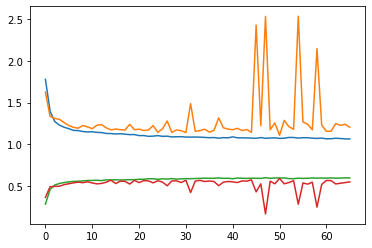

In [11]:
plt.plot(hist)

In [12]:
best_acc

0.5930495693765837